# Introduction
This Jupyter notebook (Oscillation.ipynb) contains the code used to generate the following examples for the paper "Analysis of Biochemical Oscillators Using Bond
  Graphs and Linear Control Theory" by Peter Gawthrop and Michael Pan:

- 3. Illustrative Example (system Toy)
- 4. The Sel'kov Oscillator (system Selkov)

The example
- 5. The Repressilator
is in the notebook Repressilator.ipynb

## Select system to be analysed

In [1]:
## Select system to be analysed
## NB Repressilator example is in a separate notebook: Repressilator,Repressilator.ipynb
SystemName = 'Toy'
ToyVersion = 'basic'
# ToyVersion = 'varyAct'
# ToyVersion = 'varyR'

# SystemName = 'Toycc'
# SystemName = 'Toy1'

# SystemName = 'ToyTwo'
# SystemName = 'ToyTwo3'
# SystemName = 'ToyTwo4'

# SystemName = 'Goodwin'

# SystemName = 'Selkov'
# SelkovVersion = 'basic'
# # SelkovVersion = 'varyATP'
# SelkovVersion = 'varyR'
# SystemName = 'Selkov1'
# SystemName = 'Selkov3'

In [2]:
if SystemName in ['Toy']:
    if ToyVersion in ['basic']:
        K_Act = 1
        kappa_rf = 10
        SysName = 'Toy'
    elif ToyVersion in ['varyAct']:
        K_Act = 0.2
        kappa_rf = 10
        SysName = 'Toymod'
    elif ToyVersion in ['varyR']:
        K_Act = 1
        kappa_rf = 25
        SysName = 'ToymodR'
    else:
        print('ToyVersion',ToyVersion,'not known.')
        print('K_Act=', K_Act)
elif SystemName in ['Selkov']:
    if SelkovVersion in ['basic']:
        v_ATP = 0.6
        kappa_rf = 10
        SysName = 'Selkov'
    elif SelkovVersion in ['varyATP']:
        v_ATP = 0.7
        kappa_rf = 10
        SysName = 'Selkovmod'
    elif SelkovVersion in ['varyR']:
        v_ATP = 0.6
        kappa_rf = 8
        SysName = 'SelkovmodR'
    else:
        print('SelkovVersion', SelkovVersion,'not known.')
else:
    SysName = SystemName
    v_ATP = 0.6    
    K_Act = 1
    kappa_rf = 10
print(SysName)

Toy


In [3]:
## Decide whether to compute parametric variation results - takes a long time!
ParametricVariation = False

## Save data for comparative plots and for printing equations and parameters.
SavingData = False
SaveData = SysName in ['Toy','Toy1','Toycc','ToyTwo','ToyTwo3','ToyTwo4','Toymod','ToymodR',
                    'Selkov','Selkovmod','SelkovmodR','Selkov1','Selkov3']
SaveData = SaveData and SavingData
if SaveData:
    SavedData = {}
print("Saving data =",SaveData)

Saving data = False


## Import some python code
The bond graph analysis uses a number of Python modules:

In [4]:
## For path etc: sys.path
import sys
sys.path.append("/home/peterg/WORK/Research/SystemsBiology/lib/python")


In [5]:
## Some useful imports
import BondGraphTools as bgt
import numpy as np
import sympy as sym
import scipy.optimize as opt
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from cycler import cycler
import IPython.display as disp
import copy

## Stoichiometric analysis
import stoich as st

## SVG bg representation conversion
import svgBondGraph as sbg

## Modularity
import modularBondGraph as mbg

## Control systems package
import control as con
con.config.defaults['xferfcn.display_format'] = 'zpk'
import slycot

## Stoichiometry to BG
import stoichBondGraph as stbg

## Set slycot=True if slycot is installed (see control module)
slycot=False

## For reimporting: use imp.reload(module)
import importlib as imp

# Allow output from within functions
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Saving data
import pickle

## Set quiet=False for verbose output
quiet = True

## Plot figure to folder Figs
Plotting = False

In [6]:
def printSS(s,x_ss,parameter):
    print('\n## Steady state')
    for i,spec in enumerate(s['species']):
        # print(i,spec,x_ss[i])
        val = x_ss[i]
        if not (val==1):
            print(f'x_{{{spec}}} &= {val:.2g}\\\\')
            
    print('\n## Parameters')
    for par in parameter:
        val = parameter[par]
        if not (val==1):
            print(f'{par} & {val:.2g}\\\\')

In [7]:
def zero_crossings(a):
    """Zero crossings from  positive to negative
    """
    return np.where(np.diff(np.sign(a))>0)[0]

In [8]:
def SetPlot(fontsize=14,linewidth=5,RL=False):
        ## Sizes
        plt.rcParams.update({'font.size': fontsize})
        plt.rcParams.update({'lines.linewidth': linewidth})
        plt.rcParams.update({'lines.markersize': 6*linewidth})
 
        ## set up colour cycling for plot
        if RL:
            ## Root locus colors
            default_cycler = (cycler(color=['grey','grey','r', 'g', 'b']))
        else:
            default_cycler = (cycler(color=['r', 'g', 'b']))
        plt.rc('axes', prop_cycle=default_cycler)
    
SetPlot()


In [9]:
def SaveFig(SystemName,PlotName,fontsize=14,linewidth=5,RL=False):
    if Plotting:
        SetPlot(RL=RL)
        plotname = f'Figs/{SystemName}_{PlotName}.pdf'
        plt.tight_layout()
        plt.savefig(plotname)

In [10]:
def zpk(tf,display_format='zpk'):
    p = np.real(con.poles(tf))
    z = np.real(con.zeros(tf))
    return con.zpk(z,p,1)

In [11]:
def balred(sys,n_red):
    if n_red<sys.nstates:
        return con.balred(sys,n_red)
    else:
        return sys

In [12]:
def printTF(tf):
    return tf

In [13]:
def Properties(s,sc):
    ## Pathways
    print('Paths')
    print(st.sprintp(sc))
    
    ## Conserved Moieties (Pools)
    print('Pools:')
    disp.Latex(st.sprintml(s))



In [14]:
def SetChemostatsToy(N=3,Config='Closed',quiet=False):
 
    print(f'Setting feedback loop with configuration {Config}')
    chemostats = ['fb_Act','fb_E0'] 
 
    if Config in ['Closed']:
        chemostats = chemostats
    elif Config in ['Open']:
        chemostats.append('P')
    elif Config in ['Dynamic']:
        chemostats += ['E1']
    elif Config in ['SplitLoop']:
        chemostats += ['Pf','P']
    else:
        print(f'Config={Config} not recognised')
        
    for i in range(1,N+1):
        # for comp in ['A', 'Z', 'Zf']:
        for comp in ['A', 'Zf']:
            chemostats.append(f'decr{i}_{comp}')
    return chemostats 

In [15]:
def SetChemostatsGoodwin(N=3,Config='Closed',quiet=False):
 
    print(f'Setting feedback loop with configuration {Config}')
    chemostats = ['fb_Act','fb_E0'] 
 
    if Config in ['Closed']:
        chemostats = chemostats
    elif Config in ['Open']:
        chemostats.append('P')
    elif Config in ['Dynamic']:
        chemostats += ['E1']
    elif Config in ['SplitLoop']:
        chemostats += ['Pf','P']
    else:
        print(f'Config={Config} not recognised')
        
    for i in range(1,N+1):
        for comp in ['A', 'Z', 'Zf']:
            chemostats.append(f'decr{i}_{comp}')
    return chemostats 

In [16]:
def SetChemostatsSelkov(Config='Closed',quiet=False):
    
    print(f'Setting feedback loop with configuration {Config}')
    chemostats = [] 
        
    if Config in ['Closed']:
        chemostats = chemostats
    elif Config in ['Open']:
        chemostats.append('P')
    elif Config in ['SplitLoop']:
        chemostats += ['Pf','P']
    else:
        print(f'Config={Config} not recognised')
        
    for comp in ['ATP0', 'Z', 'Zf']:
        chemostats.append(f'selkov_{comp}')
        
    return chemostats    

In [17]:
# def SetChemostatsRepressilator(Config='Closed',quiet=False):
 
#     print(f'Setting feedback loop with configuration {Config}')
#     chemostats = ['A', 'G1_XM', 'G1_XP', 'G2_XM','G2_XP','G3_XM','G3_XP']
#     if Config in ['Closed']:
#         chemostats = chemostats
#     elif Config in ['Open']:
#         chemostats.append('P3')
#     elif Config in ['SplitLoop']:
#         chemostats += ['P3f','P3']
#     else:
#         print(f'Config={Config} not recognised')
#     return chemostats 

In [18]:
def SetChemostats(SystemName,Config='Closed',quiet=False):
    if SystemName in ['Toy','Toy1','Toycc']:
        chemostats = SetChemostatsToy(N=3,Config=Config)
    elif SystemName in ['ToyTwo','ToyTwo3','ToyTwo4']:
        chemostats = SetChemostatsToy(N=2,Config=Config)
    elif SystemName in ['Goodwin']:
        chemostats = SetChemostatsGoodwin(N=3,Config=Config)
    elif SystemName in ['Selkov','Selkov1','Selkov3']:
        chemostats = SetChemostatsSelkov(Config=Config)
    # elif SystemName in ['Repressilator']:
    #     chemostats = SetChemostatsRepressilator(Config=Config)
    else:
        print('System Name',SystemName,'is not known')
        
    return chemostats

In [19]:
def stoichiometry(abg,chemostats=[]):
#     print('Comp s')
    s = st.stoich(abg,quiet=quiet)
#     print('comp sc')
    sc = st.statify(s,chemostats=chemostats)    
    return s,sc

In [20]:
def SetParameterToy(N=3,kappa_rf=1e1,K_Act=1,K_Zf=1e-6): ## K_Zf = 0.2,1e-6
    parameter = {}
    parameter['K_fb_Act'] = K_Act
    for i in range(1,N+1):
        # parameter[f'K_decr{i}_Z'] = 1 # 1e-6
        parameter[f'K_decr{i}_Zf'] = K_Zf
        parameter[f'kappa_decr{i}_r']  = 1e0
        parameter[f'kappa_decr{i}_rf'] = kappa_rf
        parameter[f'K_decr{i}_A'] = 1e2
        parameter[f'K_E{i}'] = 1
        
    return parameter


In [21]:
def SetParameterGoodwin(N=3,kappa_rf=1e1,K_Act=1,K_Z=1e-6):
    parameter = {}
    parameter['K_fb_Act'] = K_Act  
    for i in range(1,N+1):
        parameter[f'K_decr{i}_Z'] = parameter[f'K_decr{i}_Zf'] = K_Z
        if i>1:
            parameter[f'kappa_decr{i}_r']  = 1e0
        else:
            parameter[f'kappa_decr{i}_r1']  = 1e0
            parameter[f'kappa_decr{i}_r2']  = 1e6
            parameter[f'K_decr{i}_C'] = 1e-3
            
        parameter[f'kappa_decr{i}_rf'] = kappa_rf
        parameter[f'K_decr{i}_A'] = 1e2
       
    return parameter


In [22]:
def SetParameterSelkov(subname='_selkov',v_ATP=0.0,kappa_rf=1e1):
    parameter = {}
#     parameter['kappa_rd'] = 1
        
    parameter[f'K{subname}_Z'] = parameter[f'K{subname}_Zf'] = 1e-10
    parameter[f'kappa{subname}_r0']  = 1e3
    parameter[f'kappa{subname}_r1']  = 1e3
    parameter[f'kappa{subname}_r2']  = 1e3
    parameter[f'kappa{subname}_rf'] = kappa_rf
    parameter[f'K{subname}_PFK'] = 1
    parameter[f'K{subname}_C'] = 1

#     Large = 1e2
    Large = 1e3
    parameter[f'K{subname}_ATP0'] = Large
    parameter[f'kappa{subname}_rs'] = v_ATP/Large

    
    return parameter


In [23]:
def SetParameter():
    if SystemName in ['Toy','Toy1','Toycc']:
        parameter = SetParameterToy(N=3,K_Act=K_Act,kappa_rf=kappa_rf)
    elif SystemName in ['ToyTwo','ToyTwo3','ToyTwo4']:
        parameter = SetParameterToy(N=2,K_Act=K_Act,kappa_rf=kappa_rf)
    elif SystemName in ['Goodwin']:
        parameter = SetParameterGoodwin()
    elif SystemName in ['Selkov','Selkov1','Selkov3']:
        parameter = SetParameterSelkov(v_ATP=v_ATP,kappa_rf=kappa_rf)
    elif SystemName in ['Repressilator']:
        parameter = SetParameterRepressilator()
    else:
        print('System Name',SystemName,'is not known')
        
    return parameter

In [24]:
def SetAll(SystemName,Config='Closed',quiet=False):
    if SystemName in ['Toy','Toy1','Toycc']:
        chemostats = SetChemostatsToy(N=3,Config=Config)
        parameter = SetParameterToy(N=3,K_Act=K_Act,kappa_rf=kappa_rf)
        InpVar = 'fb_Act'
        OutpVar = 'P'
        T = np.linspace(0,4,1000)
        T_long = np.linspace(0,10,5000)
        n_red = 2
    elif SystemName in ['ToyTwo','ToyTwo3','ToyTwo4']:
        chemostats = SetChemostatsToy(N=2,Config=Config)
        parameter = SetParameterToy(N=2,K_Act=K_Act,kappa_rf=kappa_rf)
        InpVar = 'fb_Act'
        OutpVar = 'P'
        T = np.linspace(0,4,1000)
        T_long = np.linspace(0,10,5000)
        n_red = 2
    elif SystemName in ['Goodwin']:
        chemostats = SetChemostatsGoodwin(N=3,Config=Config)
        parameter = SetParameterGoodwin(N=3)
        InpVar = 'fb_Act'
        OutpVar = 'P'
        T = np.linspace(0,5,1000)
        T_long = np.linspace(0,20,5000)
        n_red = 3

        
    elif SystemName in ['Selkov','Selkov1','Selkov3']:
        chemostats = SetChemostatsSelkov(Config=Config)
        parameter = SetParameterSelkov(v_ATP=v_ATP,kappa_rf=kappa_rf)
        InpVar = 'selkov_ATP0'
        OutpVar = 'P'
        T = np.linspace(0,5,1000)
        T_long = np.linspace(0,50,5000)
        n_red = 2 ## Order reduction
    # elif SystemName in ['Repressilator']:
    #     chemostats = SetChemostatsRepressilator(Config=Config)
    #     parameter = SetParameterRepressilator()
    #     InpVar = 'A'
    #     OutpVar = 'P3'
    #     T = np.linspace(0,5,100)
    #     T_long = np.linspace(0,50,5000)
    else:
        print('System Name',SystemName,'is not known')
        
    return chemostats,parameter,InpVar,OutpVar,T,T_long,n_red

In [25]:
def extractSysflow(Sys,s,chemo,chemostats,reac):
    
    ## Index of reaction
    reaction = s['reaction']
    i_v = reaction.index(reac)
    
    ## Index of input
    i = chemostats.index(chemo)
  
    sys = con.ss(Sys.A,Sys.B[:,i],Sys.C[i_v,:],Sys.D[i_v,i])
    
    return sys

def extractSysdX(Sys,s,chemo,chemostats,outp,tol=None):
    
    ## Index of output
    species = s['species']
    i_v = species.index(outp)
    
    ## Index of input
    i = chemostats.index(chemo)
  
    sys = con.ss(Sys.A,Sys.B[:,i],Sys.C[i_v,:],Sys.D[i_v,i])
    
    return con.minreal(sys,tol=tol)

In [26]:
def IntegrateTF(L0,crite=1e-4):
    num0 = L0.num[0][0]
    den0 = L0.den[0][0]
#     print(den0)
    ln = len(num0)
    if (abs(num0[ln-1])<crite):
        ## remove s factor in numerator
        num = num0[:ln-1]
        den = den0
    else:
        ## Integrator
        ld = len(den0)
        num = num0
        den = np.zeros(ld+1)  
        den[:ld] = den0

    L = con.tf(num,den)
    return L

In [27]:
def Lin(s,sc,parameter=None,x_ss=None,outvar='dX',Inp=['P','E'], Outp=['P','E'],quiet=True):

    ## Linearise
    SYS = st.lin(s,sc,x_ss=x_ss,parameter=parameter,outvar='dX',quiet=quiet)

    # Extract individual transfer functions
    TF = {}
    Sys = {}
    for inp in Inp:
        for outp in Outp:
            if not quiet:
                print(inp,'-->',outp)
            sys = extractSysdX(SYS,s,inp,chemostats,outp)
            tf = con.tf(sys)
            Sys[f'{inp}_{outp}'] = sys
            TF[f'{inp}_{outp}'] = tf
            if not quiet:
                print(tf)

    return TF,Sys

In [28]:
def step_response(sys,T=None):
    resp = con.step_response(sys,T=T)
    t = resp.t
    y = np.array(resp.y).flatten()
    plt.plot(t,y)
    return y

In [29]:
def impulse_response(sys,T=None):
    resp = con.impulse_response(sys,T=T)
    t = resp.t
    y = np.array(resp.y).flatten()
    plt.plot(t,y)
    return y

In [30]:
def SteadyState(s,sc,parameter,x0,OutpVar='P',returnAll=False):
    
    t = np.linspace(0,1e4)
    ndat = st.sim(s,sc=sc,t=t,parameter=parameter,X0=x0,quiet=True)
    x_ss = ndat['X'][-1,:]
    
    ## Flow into P
    species = s['species']
    v_ss = ndat['dX'][-1,species.index(OutpVar)]
    
    if returnAll:
        SS = {}
        ## Save up all steady-state data
        for key in ndat:
            if not key in ['t']:
#                 print(key)
                SS[key] = ndat[key][-1,:]
        return x_ss,v_ss,SS
    else:
        return x_ss,v_ss

def func(x_P):
    
    x0 = np.ones(s['n_X'])
    x0[species.index(OutpVar)] = x_P
    x_ss,v_ss = SteadyState(s,sc,parameter,x0,OutpVar=OutpVar)
    return v_ss

def findSteadyState(s,sc,parameter,x0,OutpVar='P',returnAll=False):
    
    species = s['species']
    root = opt.fsolve(func,1)
    
    x_P_ss = root[0]
    
    x0[species.index(OutpVar)] = x_P_ss
    
    if returnAll:
        x_ss,v_ss,SS = SteadyState(s,sc,parameter,x0,OutpVar=OutpVar,returnAll=returnAll)
        return x_ss,SS
    else:
        x_ss,v_ss = SteadyState(s,sc,parameter,x0,OutpVar=OutpVar,returnAll=returnAll)
        return x_ss,x_P_ss

# Submodels

    - decr: basic enzyme reaction with degredation
    - decrc: basic enzyme reaction with degredation and cooperativity
    - dECR: enzyme reaction with intermediate complex and degredation
    - dECRc: enzyme reaction withintermediate complex and degredation and cooperativity
    - ActInh: activation/inhibition module
    - Selkov: The Sel'kov model of glycolitic oscillations from Keener and Sneyd



Using decr_abg.svg


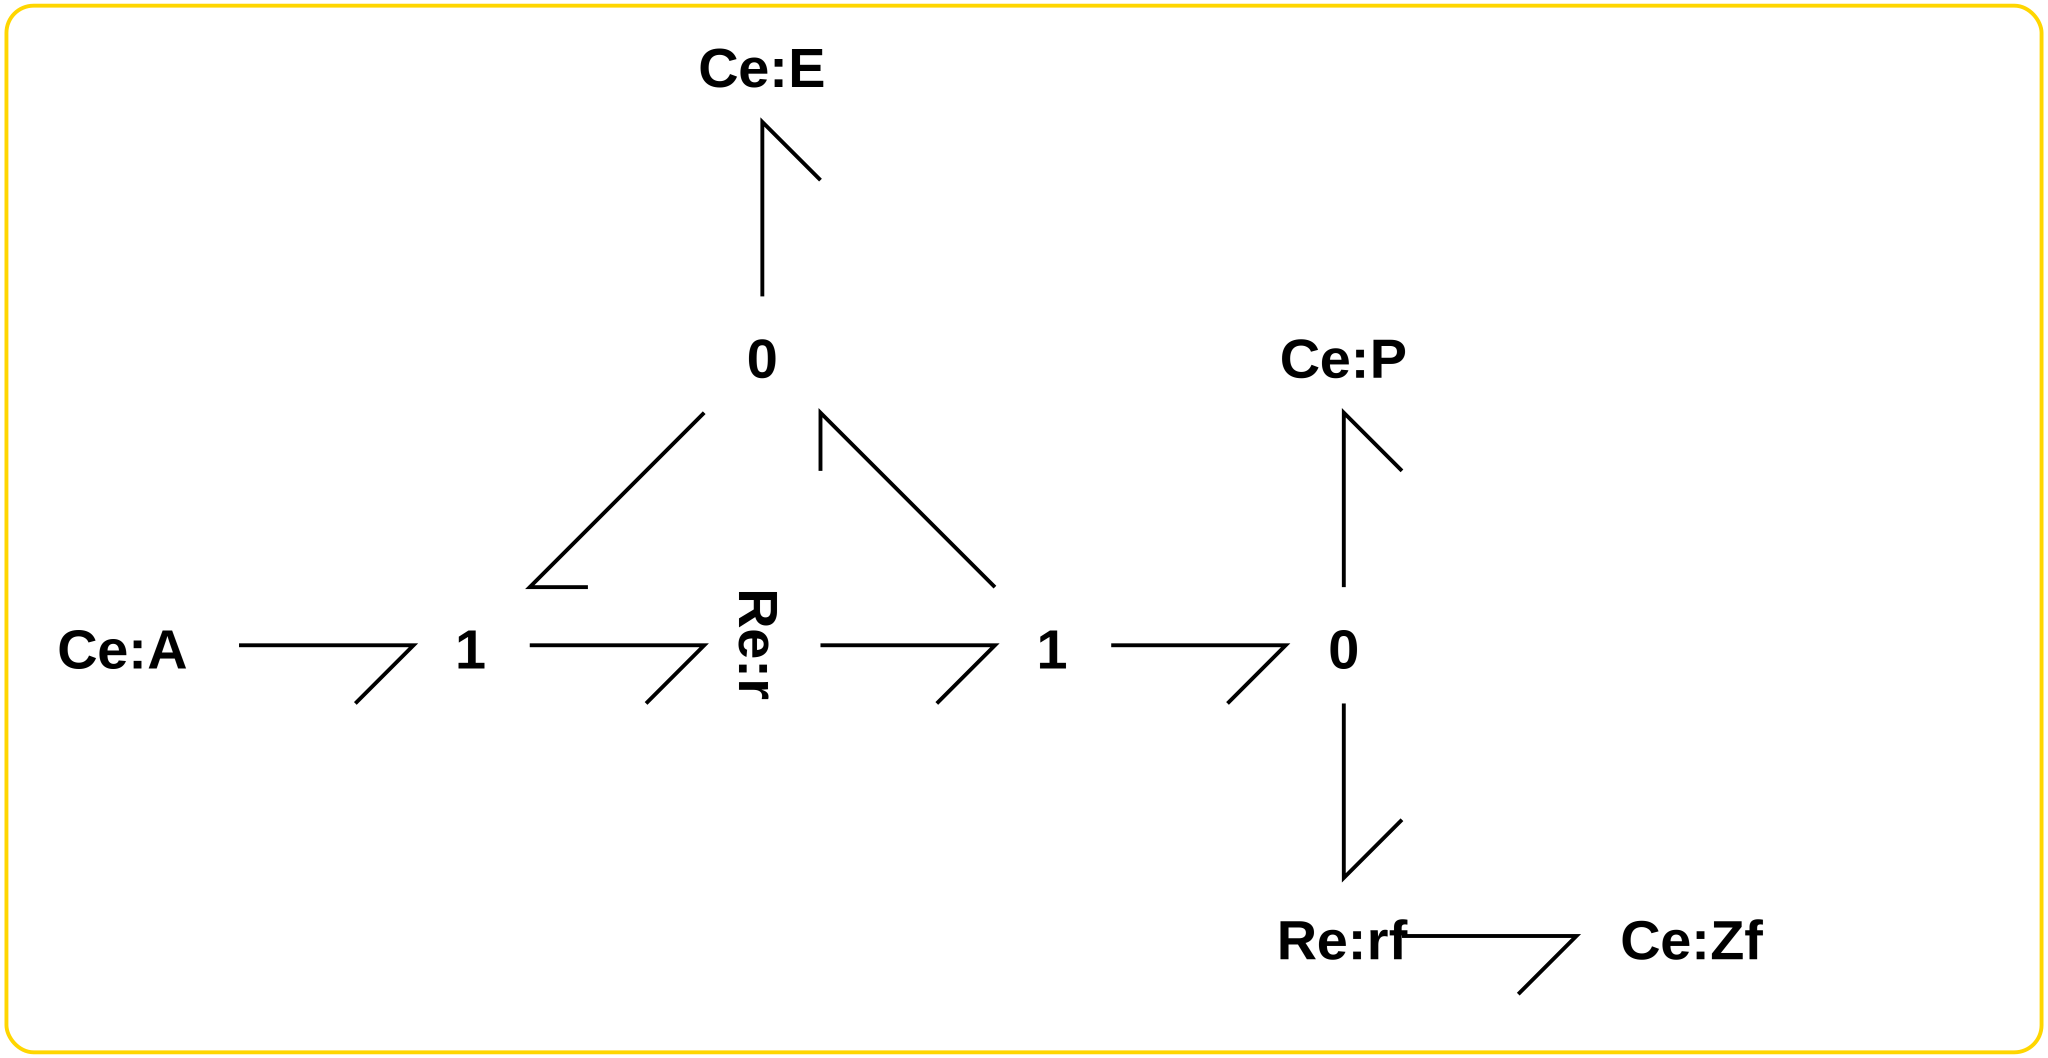

{}


<module 'decr_abg' from '/home/peterg/WORK/Research/SystemsBiology/Notes/2024/Oscillation/decr_abg.py'>

['A', 'E', 'P', 'Zf']


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

\begin{align}
\ch{A + E & <> [ r ] E + P }\\
\ch{P & <> [ rf ] Zf }
\end{align}

\begin{align}
v_{r} &= K_{E} \kappa_{r} x_{E} \left(K_{A} x_{A} - K_{P} x_{P}\right)\\
v_{rf} &= \kappa_{rf} \left(K_{P} x_{P} - K_{Zf} x_{Zf}\right)
\end{align}

Setting K_A to 1
Setting K_Zf to 1e-06
Setting kappa_r to 1000
Setting kappa_rf to 10
0 states have been removed from the model
E  -  E


/home/peterg/anaconda3/envs/bgt/lib/python3.8/site-packages/scipy/signal/_filter_design.py:1746: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  warnings.warn("Badly conditioned filter coefficients (numerator): the "
/home/peterg/anaconda3/envs/bgt/lib/python3.8/site-packages/scipy/signal/_filter_design.py:1091: RuntimeWarning: invalid value encountered in divide
  b /= b[0]


TransferFunction(array([0.]), array([1.]))

0 states have been removed from the model
E  -  P


TransferFunction(array([0.]), array([1.]))

0 states have been removed from the model
P  -  E


TransferFunction(array([0.]), array([1.]))

0 states have been removed from the model
P  -  P


TransferFunction(array([-1010.]), array([1.]))



Using decrc_abg.svg


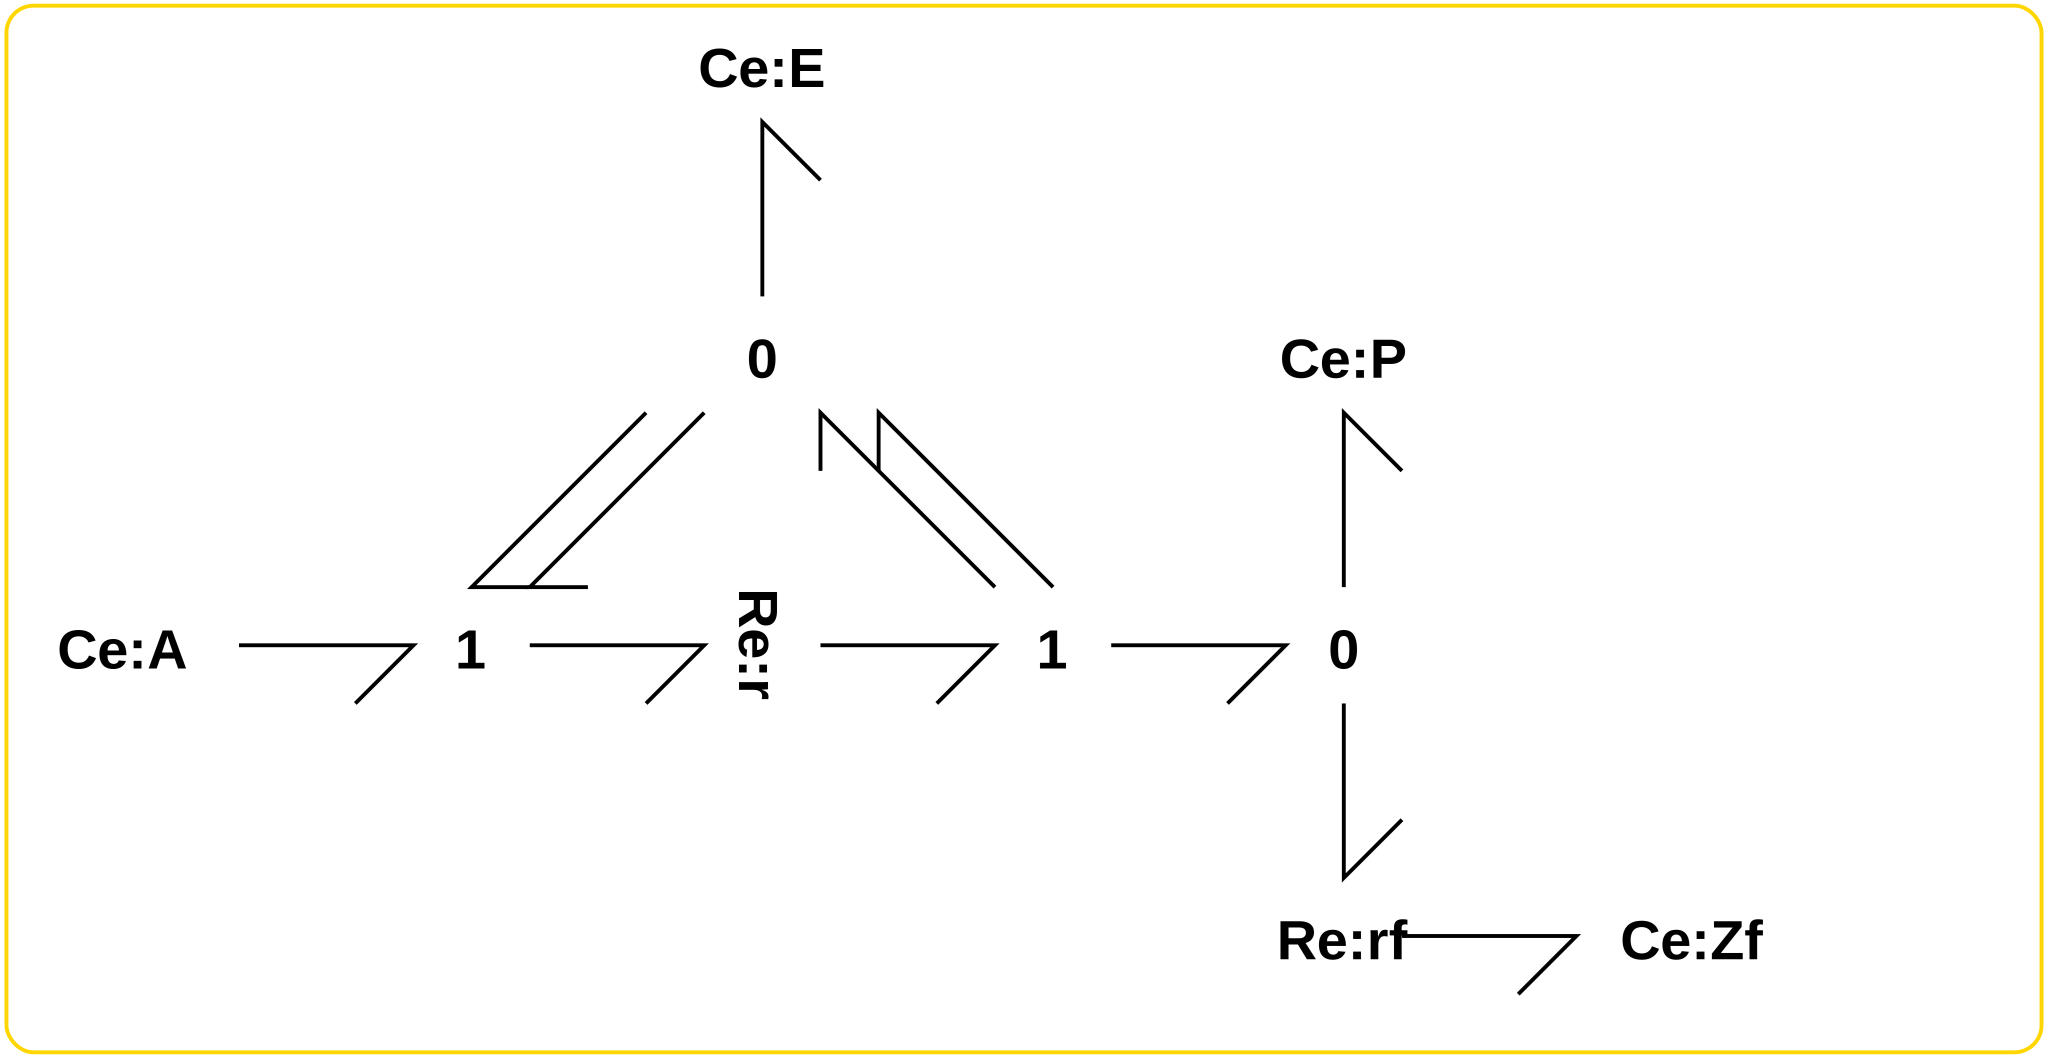

{}


<module 'decrc_abg' from '/home/peterg/WORK/Research/SystemsBiology/Notes/2024/Oscillation/decrc_abg.py'>

['A', 'E', 'P', 'Zf']


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

\begin{align}
\ch{A + 2 E & <> [ r ] 2 E + P }\\
\ch{P & <> [ rf ] Zf }
\end{align}

\begin{align}
v_{r} &= K_{E}^{2} \kappa_{r} x_{E}^{2} \left(K_{A} x_{A} - K_{P} x_{P}\right)\\
v_{rf} &= \kappa_{rf} \left(K_{P} x_{P} - K_{Zf} x_{Zf}\right)
\end{align}

Setting K_A to 1
Setting K_Zf to 1e-06
Setting kappa_r to 1000
Setting kappa_rf to 10
0 states have been removed from the model
E  -  E


TransferFunction(array([0.]), array([1.]))

0 states have been removed from the model
E  -  P


TransferFunction(array([0.]), array([1.]))

0 states have been removed from the model
P  -  E


TransferFunction(array([0.]), array([1.]))

0 states have been removed from the model
P  -  P


TransferFunction(array([-1010.]), array([1.]))



Using decrc3_abg.svg


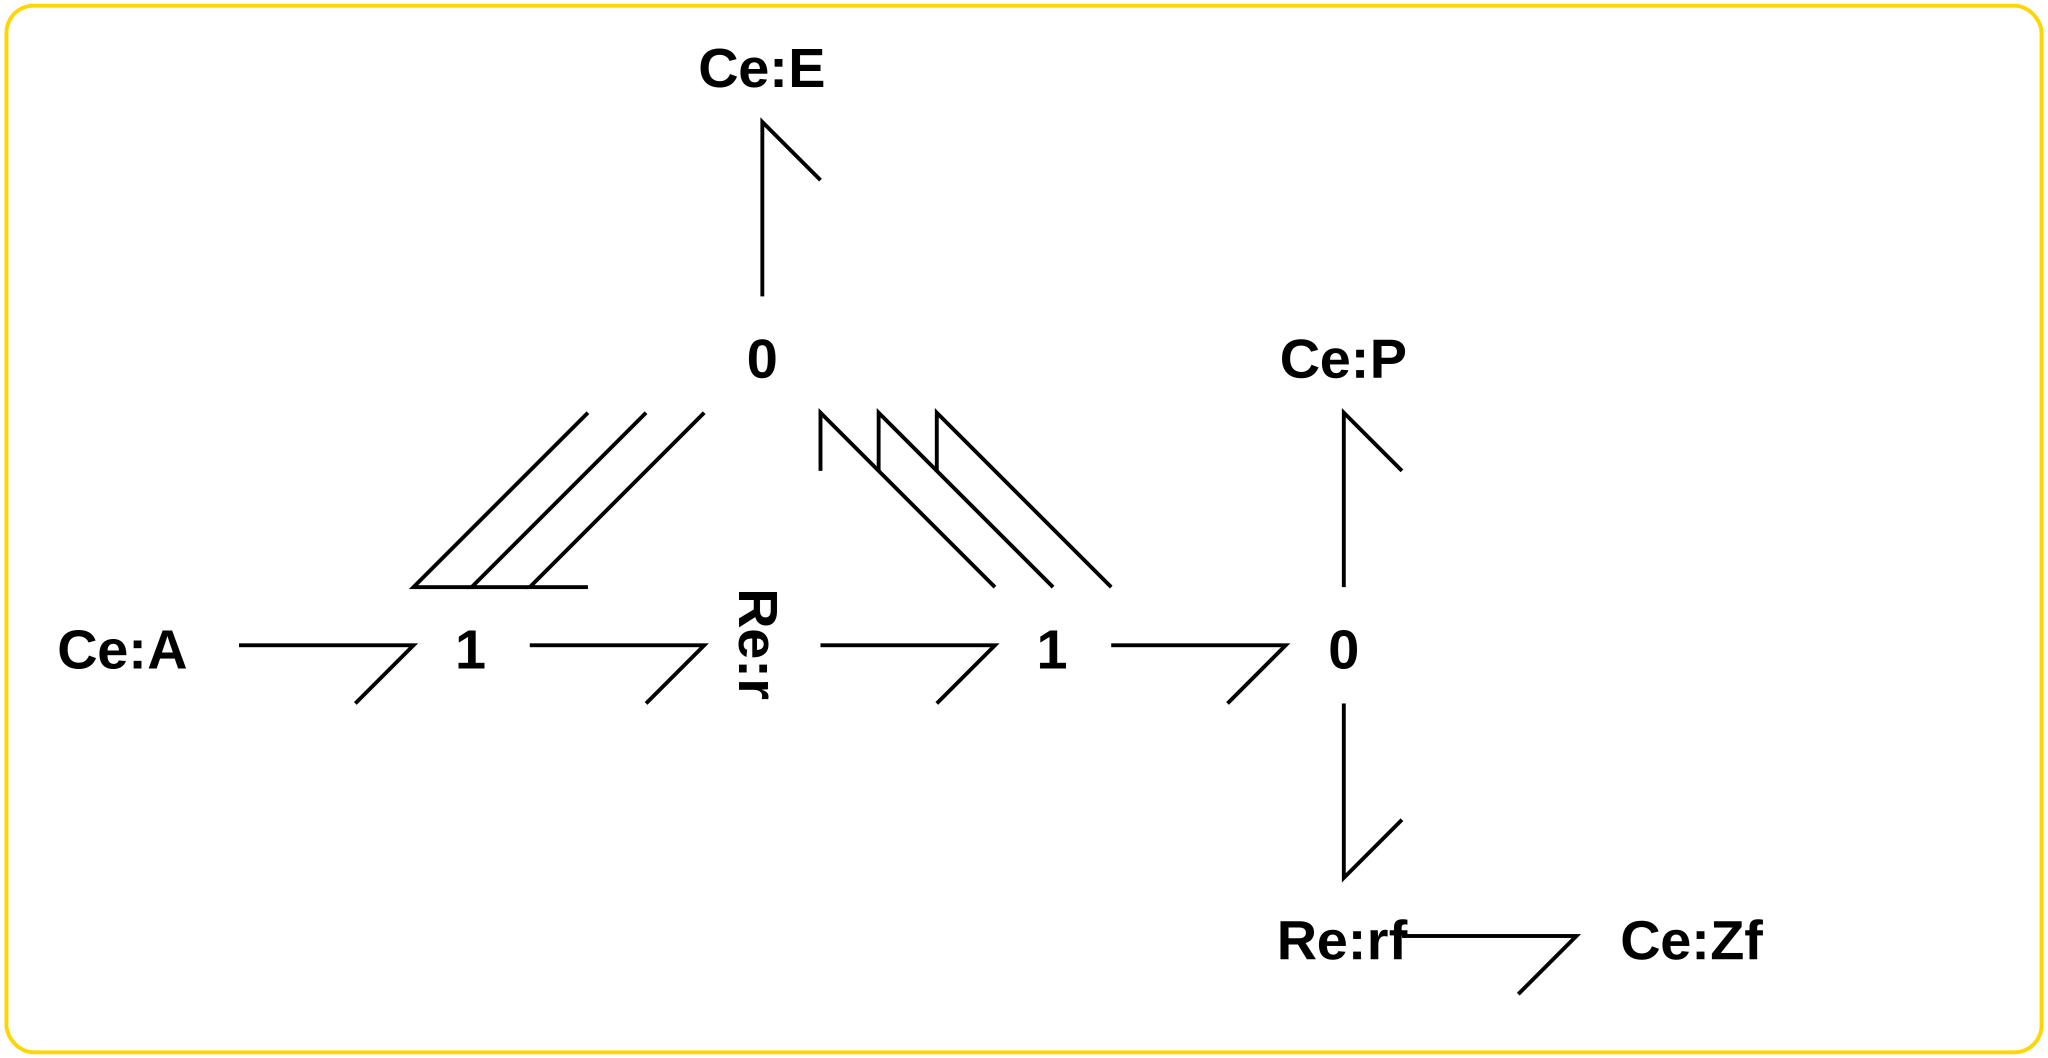

{}


<module 'decrc3_abg' from '/home/peterg/WORK/Research/SystemsBiology/Notes/2024/Oscillation/decrc3_abg.py'>

['A', 'E', 'P', 'Zf']


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

\begin{align}
\ch{A + 3 E & <> [ r ] 3 E + P }\\
\ch{P & <> [ rf ] Zf }
\end{align}

\begin{align}
v_{r} &= K_{E}^{3} \kappa_{r} x_{E}^{3} \left(K_{A} x_{A} - K_{P} x_{P}\right)\\
v_{rf} &= \kappa_{rf} \left(K_{P} x_{P} - K_{Zf} x_{Zf}\right)
\end{align}

Setting K_A to 1
Setting K_Zf to 1e-06
Setting kappa_r to 1000
Setting kappa_rf to 10
0 states have been removed from the model
E  -  E


TransferFunction(array([0.]), array([1.]))

0 states have been removed from the model
E  -  P


TransferFunction(array([0.]), array([1.]))

0 states have been removed from the model
P  -  E


TransferFunction(array([0.]), array([1.]))

0 states have been removed from the model
P  -  P


TransferFunction(array([-1010.]), array([1.]))



Using decrc4_abg.svg


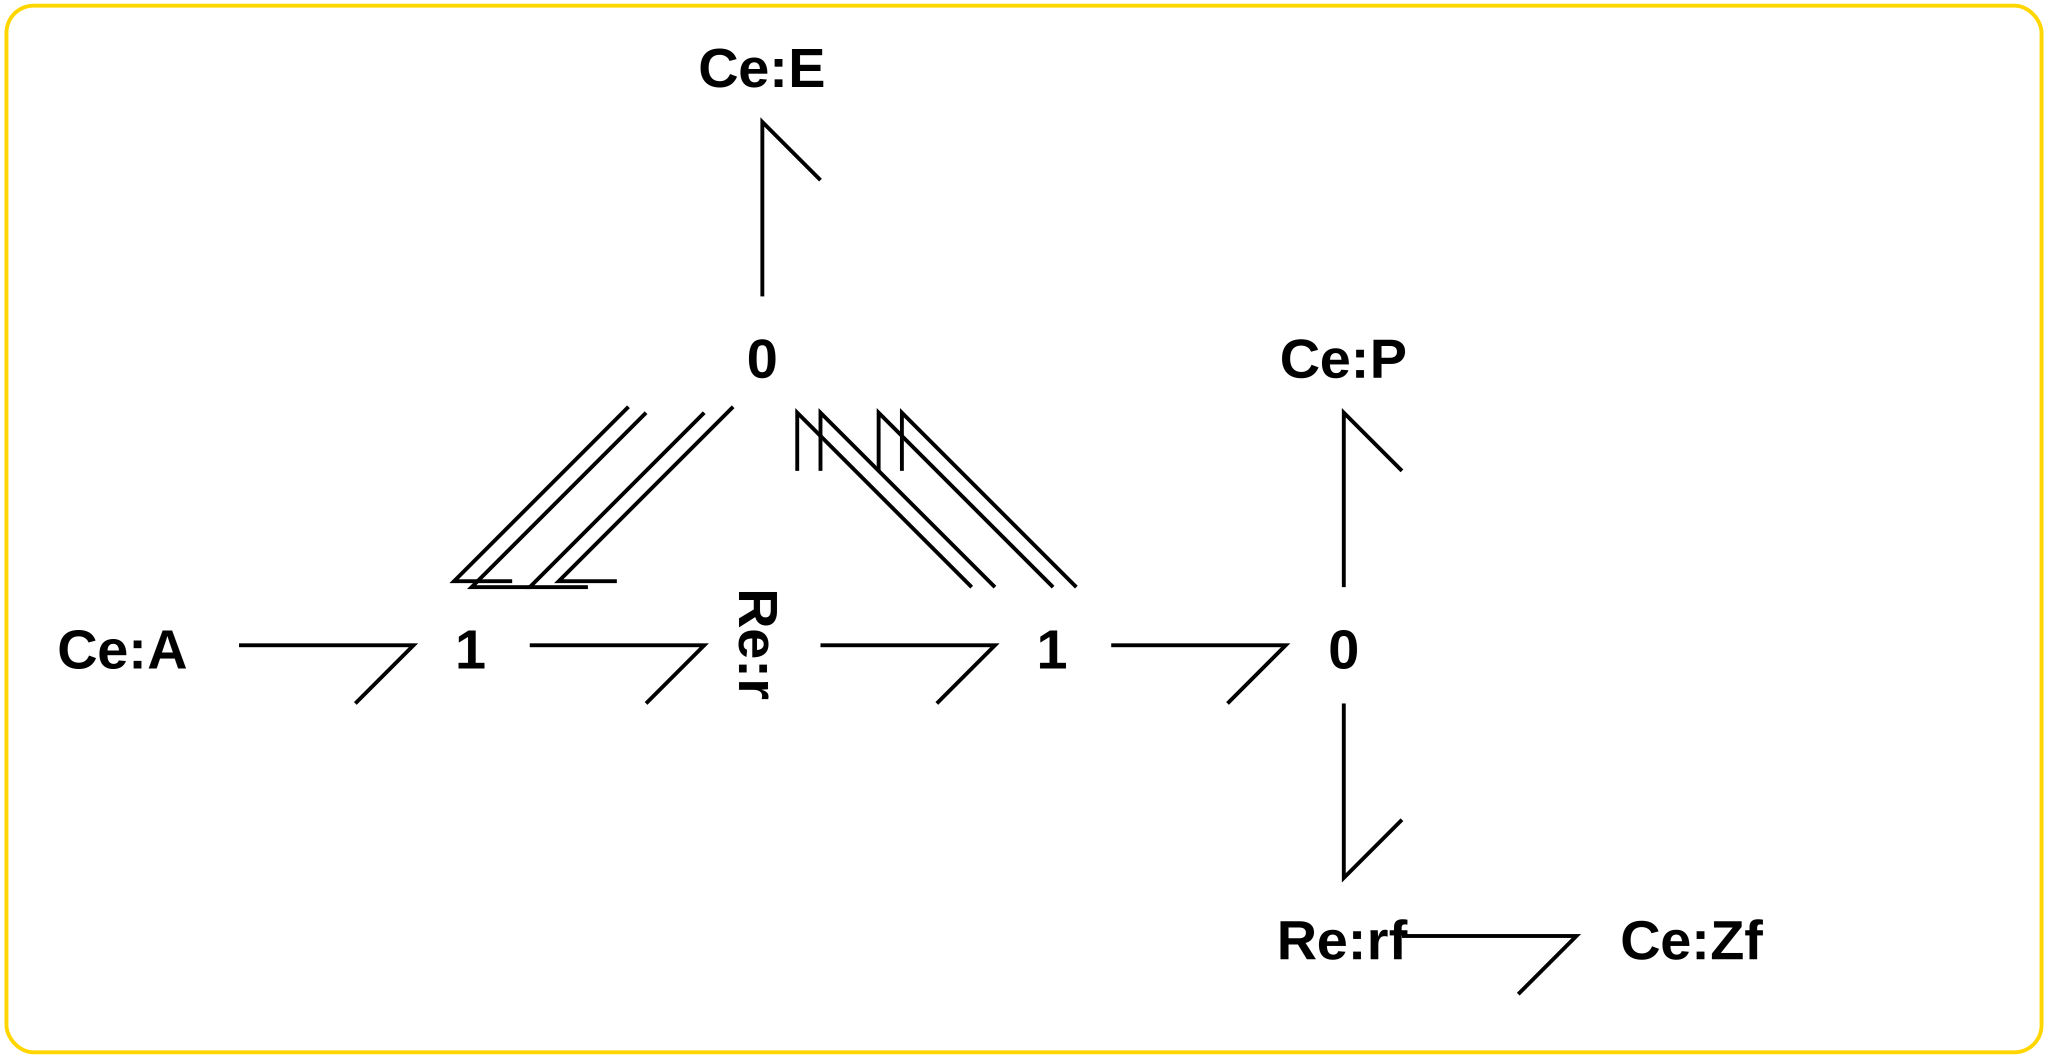

{}


<module 'decrc4_abg' from '/home/peterg/WORK/Research/SystemsBiology/Notes/2024/Oscillation/decrc4_abg.py'>

['A', 'E', 'P', 'Zf']


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

\begin{align}
\ch{A + 4 E & <> [ r ] 4 E + P }\\
\ch{P & <> [ rf ] Zf }
\end{align}

\begin{align}
v_{r} &= K_{E}^{4} \kappa_{r} x_{E}^{4} \left(K_{A} x_{A} - K_{P} x_{P}\right)\\
v_{rf} &= \kappa_{rf} \left(K_{P} x_{P} - K_{Zf} x_{Zf}\right)
\end{align}

Setting K_A to 1
Setting K_Zf to 1e-06
Setting kappa_r to 1000
Setting kappa_rf to 10
0 states have been removed from the model
E  -  E


TransferFunction(array([0.]), array([1.]))

0 states have been removed from the model
E  -  P


TransferFunction(array([0.]), array([1.]))

0 states have been removed from the model
P  -  E


TransferFunction(array([0.]), array([1.]))

0 states have been removed from the model
P  -  P


TransferFunction(array([-1010.]), array([1.]))



Using dECR_abg.svg


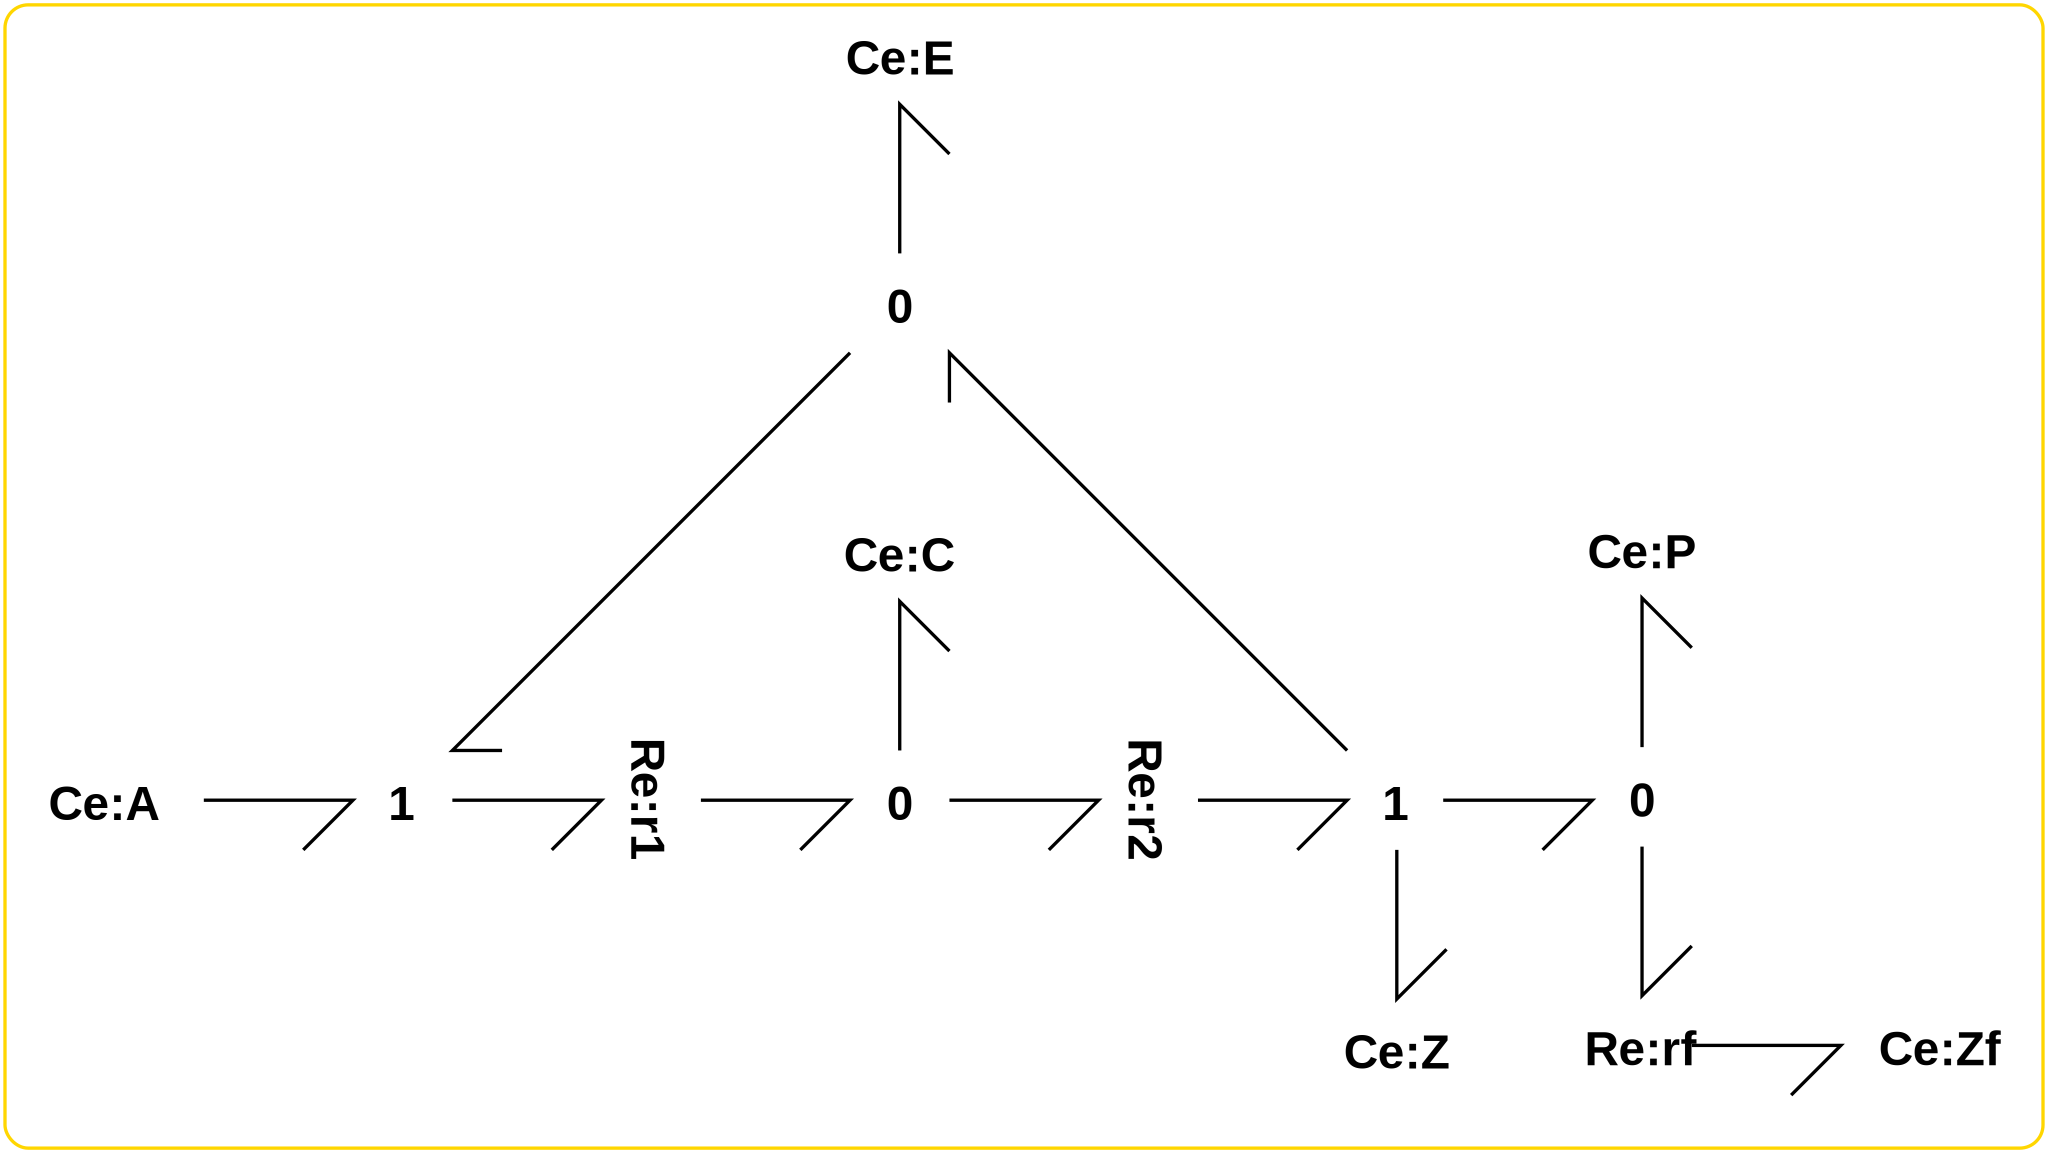

{}


<module 'dECR_abg' from '/home/peterg/WORK/Research/SystemsBiology/Notes/2024/Oscillation/dECR_abg.py'>

['A', 'C', 'E', 'P', 'Z', 'Zf']


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

\begin{align}
\ch{A + E & <> [ r1 ] C }\\
\ch{C & <> [ r2 ] E + P + Z }\\
\ch{P & <> [ rf ] Zf }
\end{align}

\begin{align}
v_{r1} &= \kappa_{r1} \left(K_{A} K_{E} x_{A} x_{E} - K_{C} x_{C}\right)\\
v_{r2} &= \kappa_{r2} \left(K_{C} x_{C} - K_{E} K_{P} K_{Z} x_{E} x_{P} x_{Z}\right)\\
v_{rf} &= \kappa_{rf} \left(K_{P} x_{P} - K_{Zf} x_{Zf}\right)
\end{align}

Setting K_A to 1
Setting K_Zf to 1e-06
Setting kappa_r1 to 2000
Setting kappa_r2 to 2000
Setting kappa_rf to 10
0 states have been removed from the model
E  -  E


TransferFunction(array([-4.0000000e+03, -4.0000000e+06,  5.7220459e-06]), array([1.e+00, 6.e+03, 4.e+06]))

0 states have been removed from the model
E  -  P


TransferFunction(array([-2.00000000e+03,  5.58793545e-09,  3.81469727e-06]), array([1.e+00, 6.e+03, 4.e+06]))

0 states have been removed from the model
P  -  E


TransferFunction(array([-2.00000000e+03,  1.86264515e-09, -1.90734863e-06]), array([1.e+00, 6.e+03, 4.e+06]))

0 states have been removed from the model
P  -  P


TransferFunction(array([-2.01e+03, -4.06e+06, -4.00e+07]), array([1.e+00, 6.e+03, 4.e+06]))



Using dECRc_abg.svg


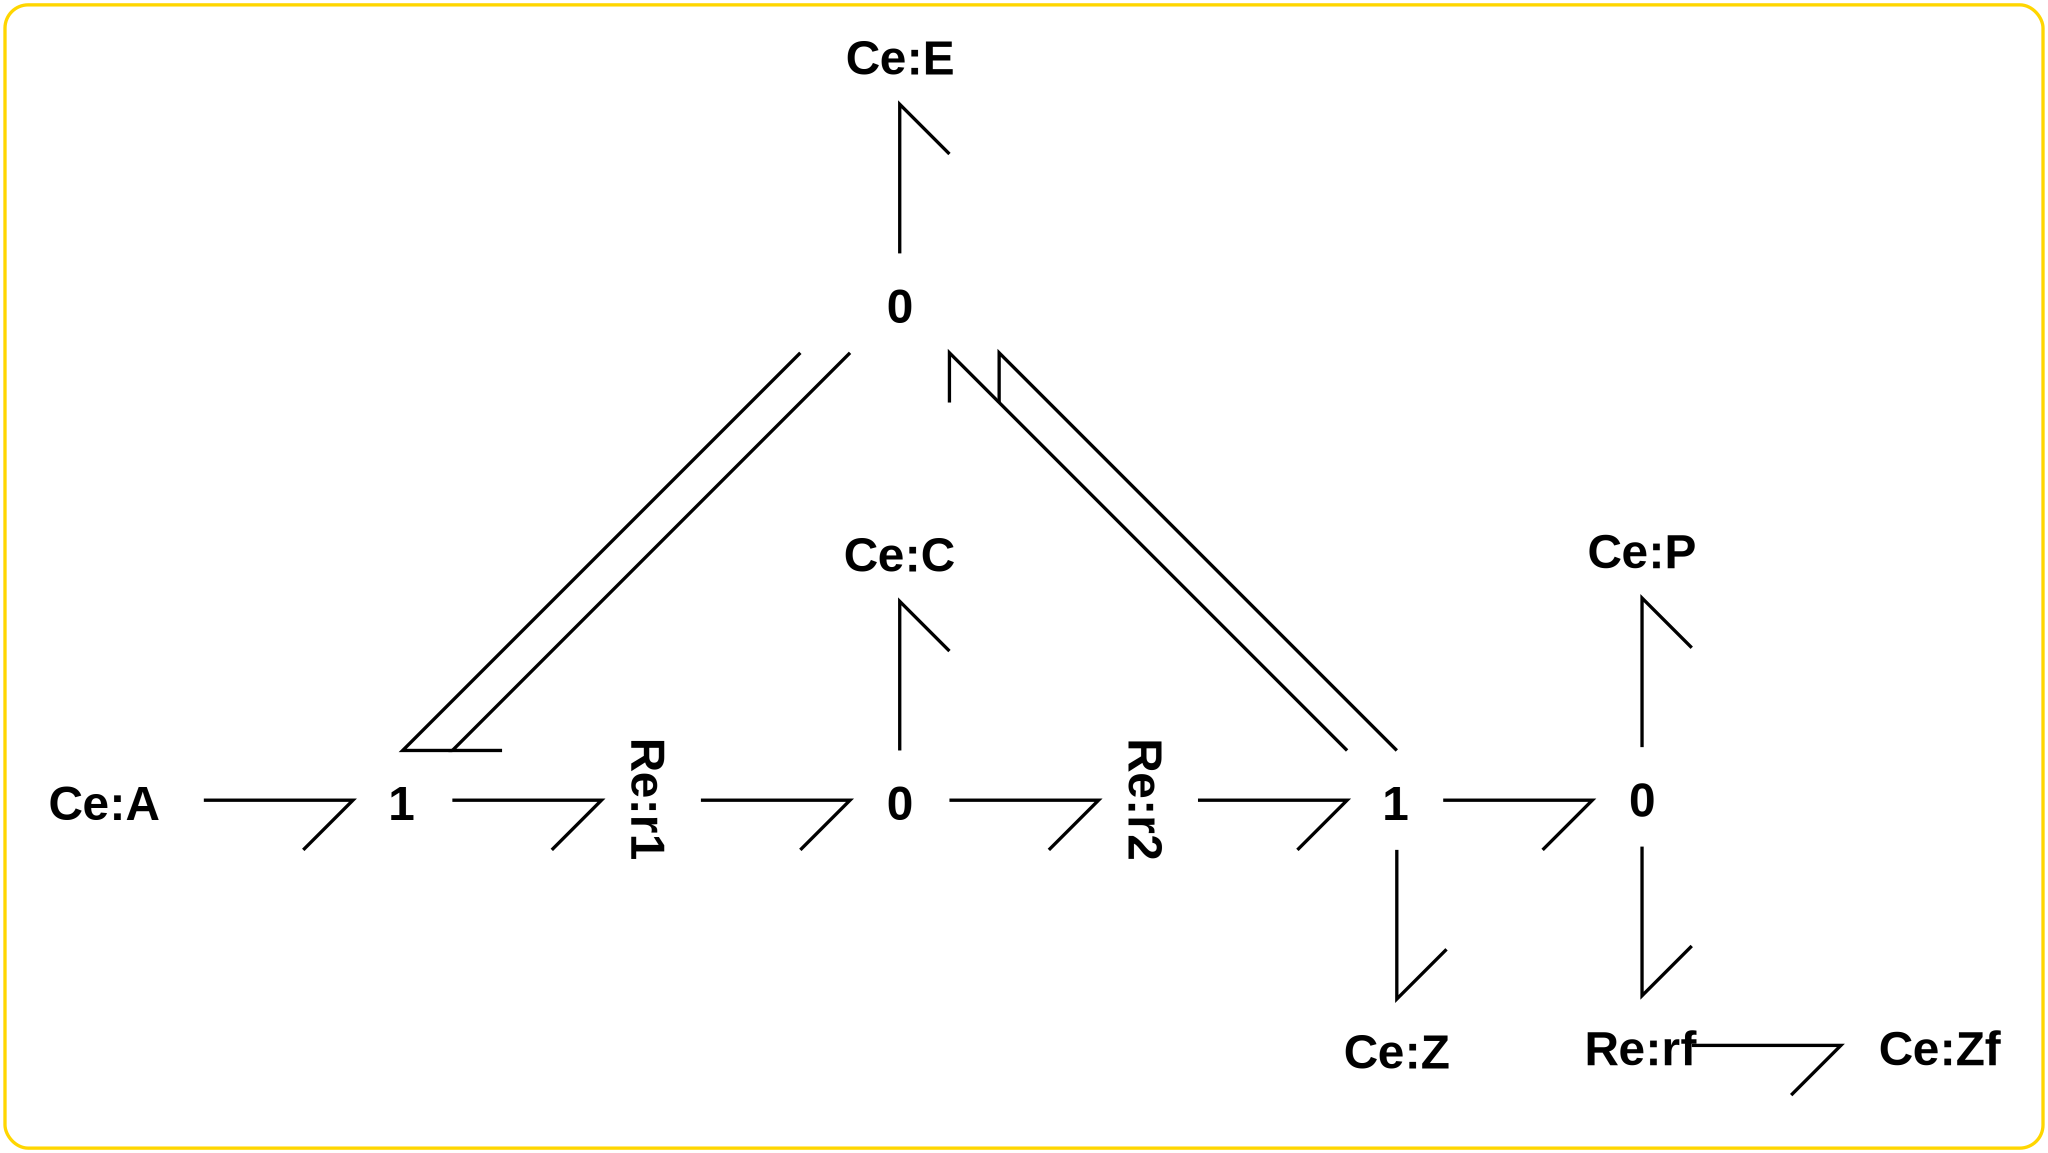

{}


<module 'dECRc_abg' from '/home/peterg/WORK/Research/SystemsBiology/Notes/2024/Oscillation/dECRc_abg.py'>

['A', 'C', 'E', 'P', 'Z', 'Zf']


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

\begin{align}
\ch{A + 2 E & <> [ r1 ] C }\\
\ch{C & <> [ r2 ] 2 E + P + Z }\\
\ch{P & <> [ rf ] Zf }
\end{align}

\begin{align}
v_{r1} &= \kappa_{r1} \left(K_{A} K_{E}^{2} x_{A} x_{E}^{2} - K_{C} x_{C}\right)\\
v_{r2} &= \kappa_{r2} \left(K_{C} x_{C} - K_{E}^{2} K_{P} K_{Z} x_{E}^{2} x_{P} x_{Z}\right)\\
v_{rf} &= \kappa_{rf} \left(K_{P} x_{P} - K_{Zf} x_{Zf}\right)
\end{align}

Setting K_A to 1
Setting K_Zf to 1e-06
Setting kappa_r1 to 2000
Setting kappa_r2 to 2000
Setting kappa_rf to 10
0 states have been removed from the model
E  -  E


TransferFunction(array([-1.60000000e+04, -1.60000000e+07,  2.28881836e-05]), array([1.e+00, 6.e+03, 4.e+06]))

0 states have been removed from the model
E  -  P


TransferFunction(array([-4.00000000e+03,  1.11758709e-08,  7.62939453e-06]), array([1.e+00, 6.e+03, 4.e+06]))

0 states have been removed from the model
P  -  E


TransferFunction(array([-4.00000000e+03,  3.72529030e-09, -3.81469727e-06]), array([1.e+00, 6.e+03, 4.e+06]))

0 states have been removed from the model
P  -  P


TransferFunction(array([-2.01e+03, -4.06e+06, -4.00e+07]), array([1.e+00, 6.e+03, 4.e+06]))



Using ActInh_abg.svg


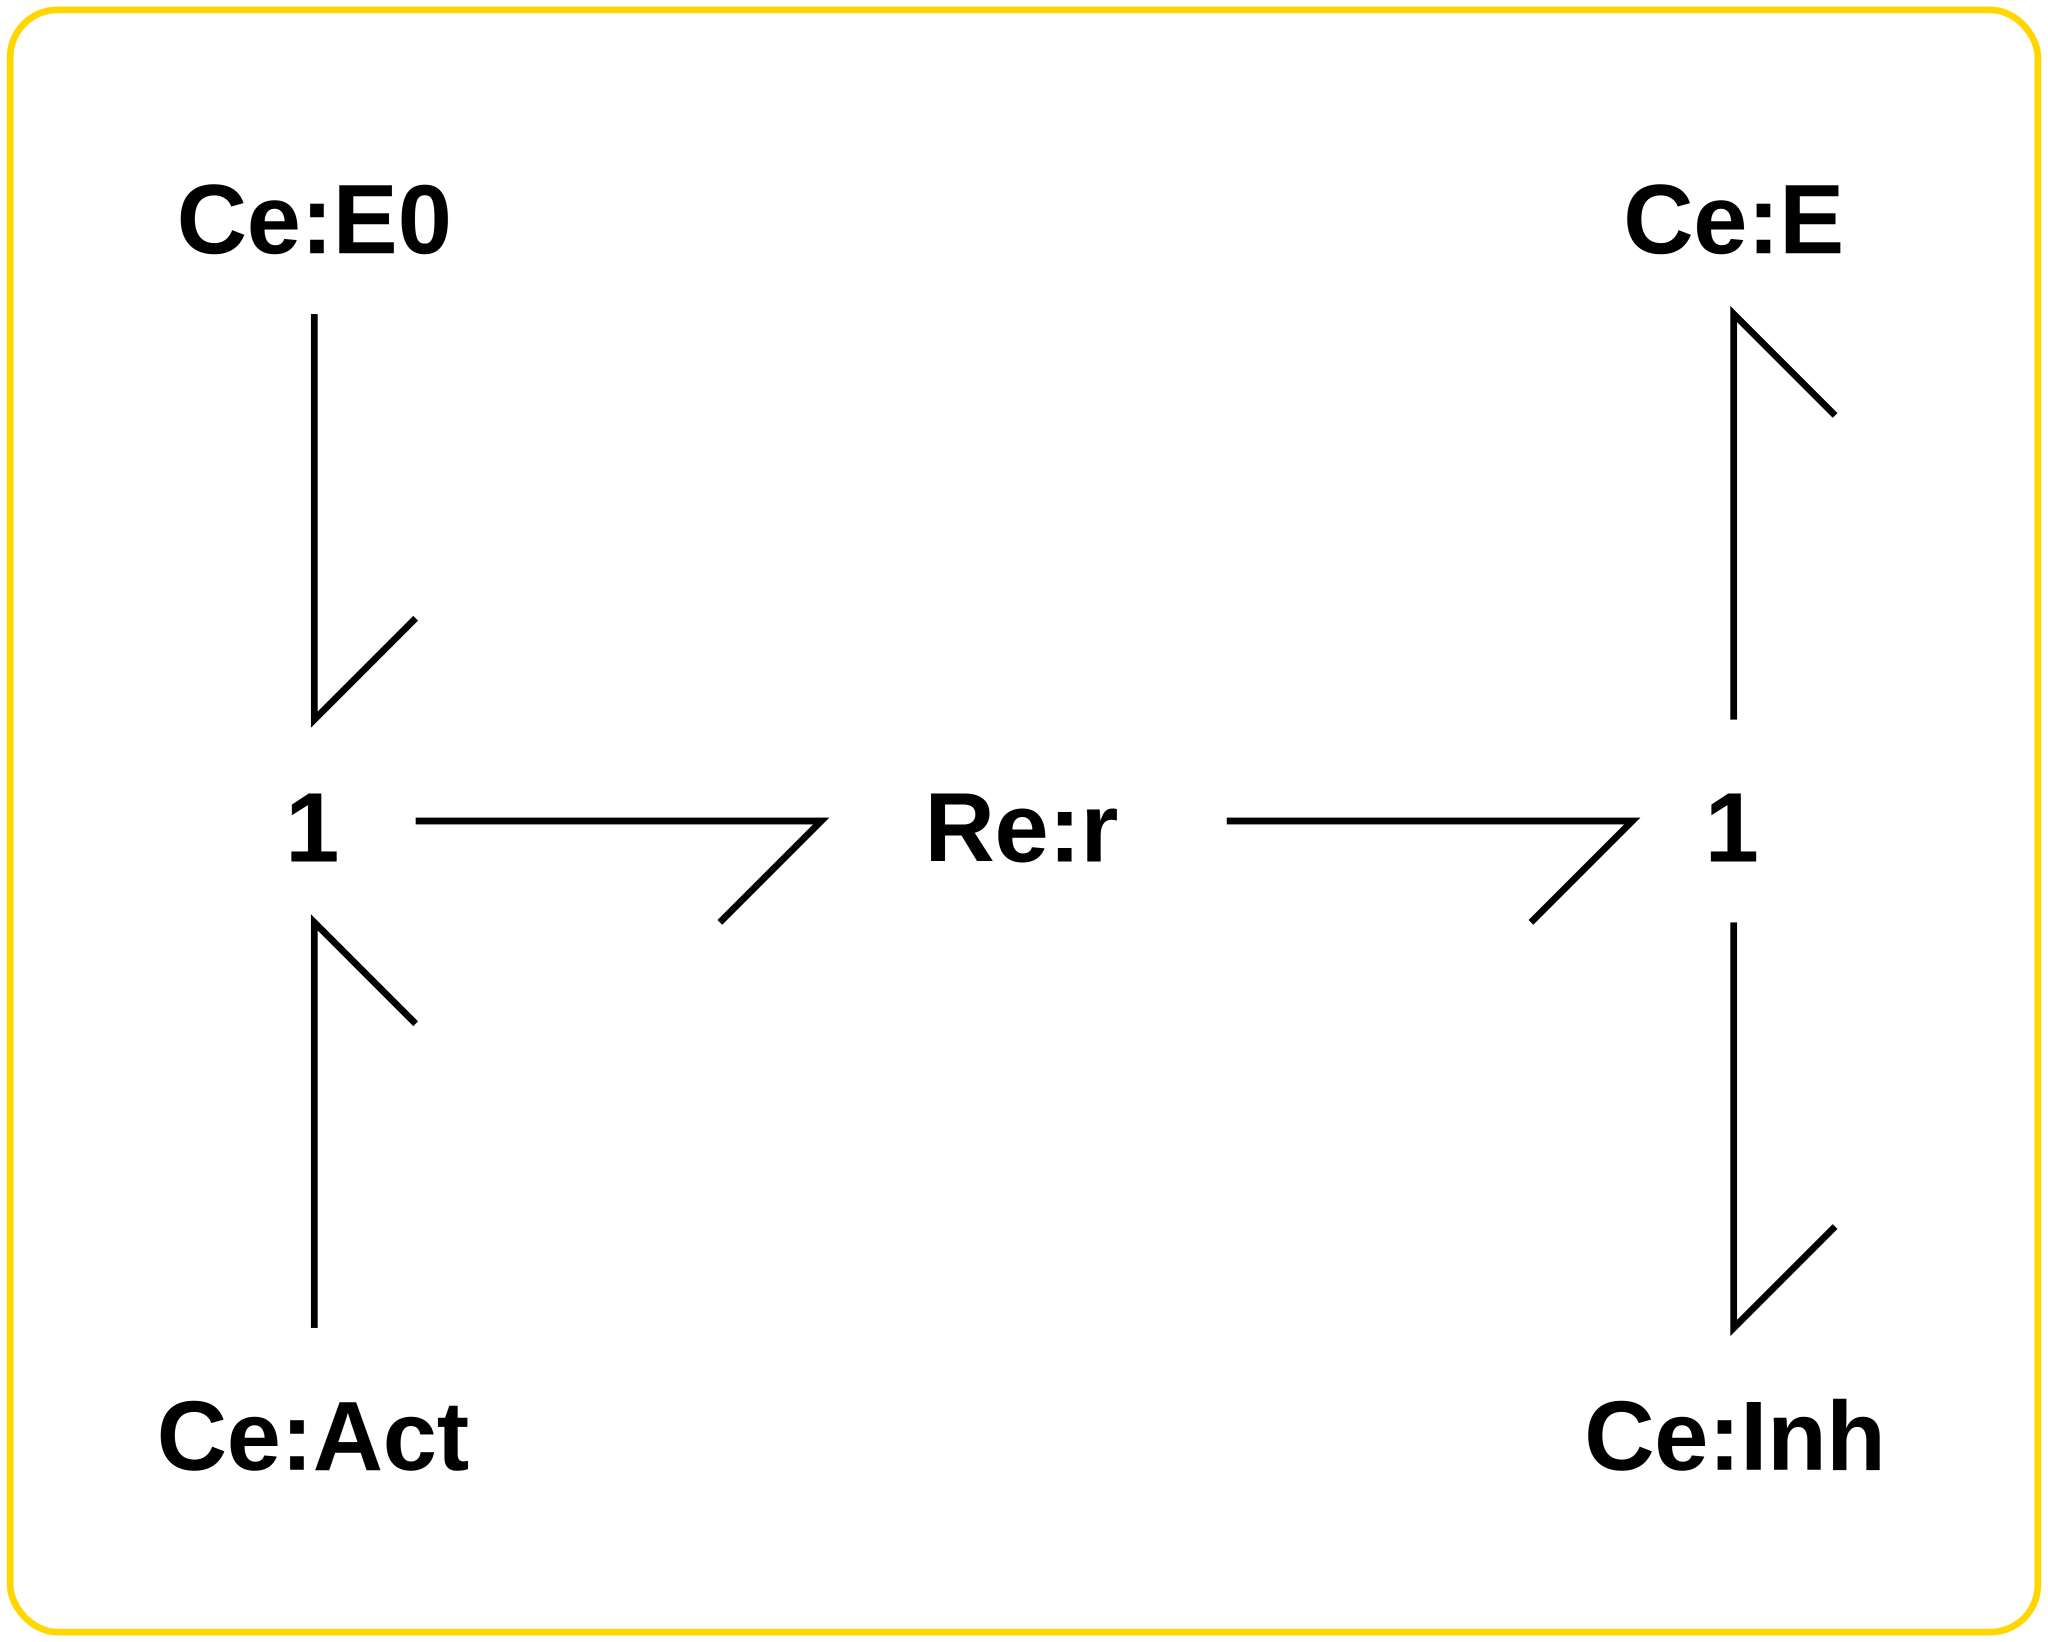

{}


<module 'ActInh_abg' from '/home/peterg/WORK/Research/SystemsBiology/Notes/2024/Oscillation/ActInh_abg.py'>

['Act', 'E', 'E0', 'Inh']


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

\begin{align}
\ch{Act + E0 & <> [ r ] E + Inh }
\end{align}

\begin{align}
v_{r} &= \kappa_{r} \left(K_{Act} K_{E0} x_{Act} x_{E0} - K_{E} K_{Inh} x_{E} x_{Inh}\right)
\end{align}

0 states have been removed from the model
Inh  -  Inh


TransferFunction(array([-1.]), array([1.]))

0 states have been removed from the model
Inh  -  E


TransferFunction(array([-1.]), array([1.]))

0 states have been removed from the model
E  -  Inh


TransferFunction(array([-1.]), array([1.]))

0 states have been removed from the model
E  -  E


TransferFunction(array([-1.]), array([1.]))



Using Selkov_abg.svg


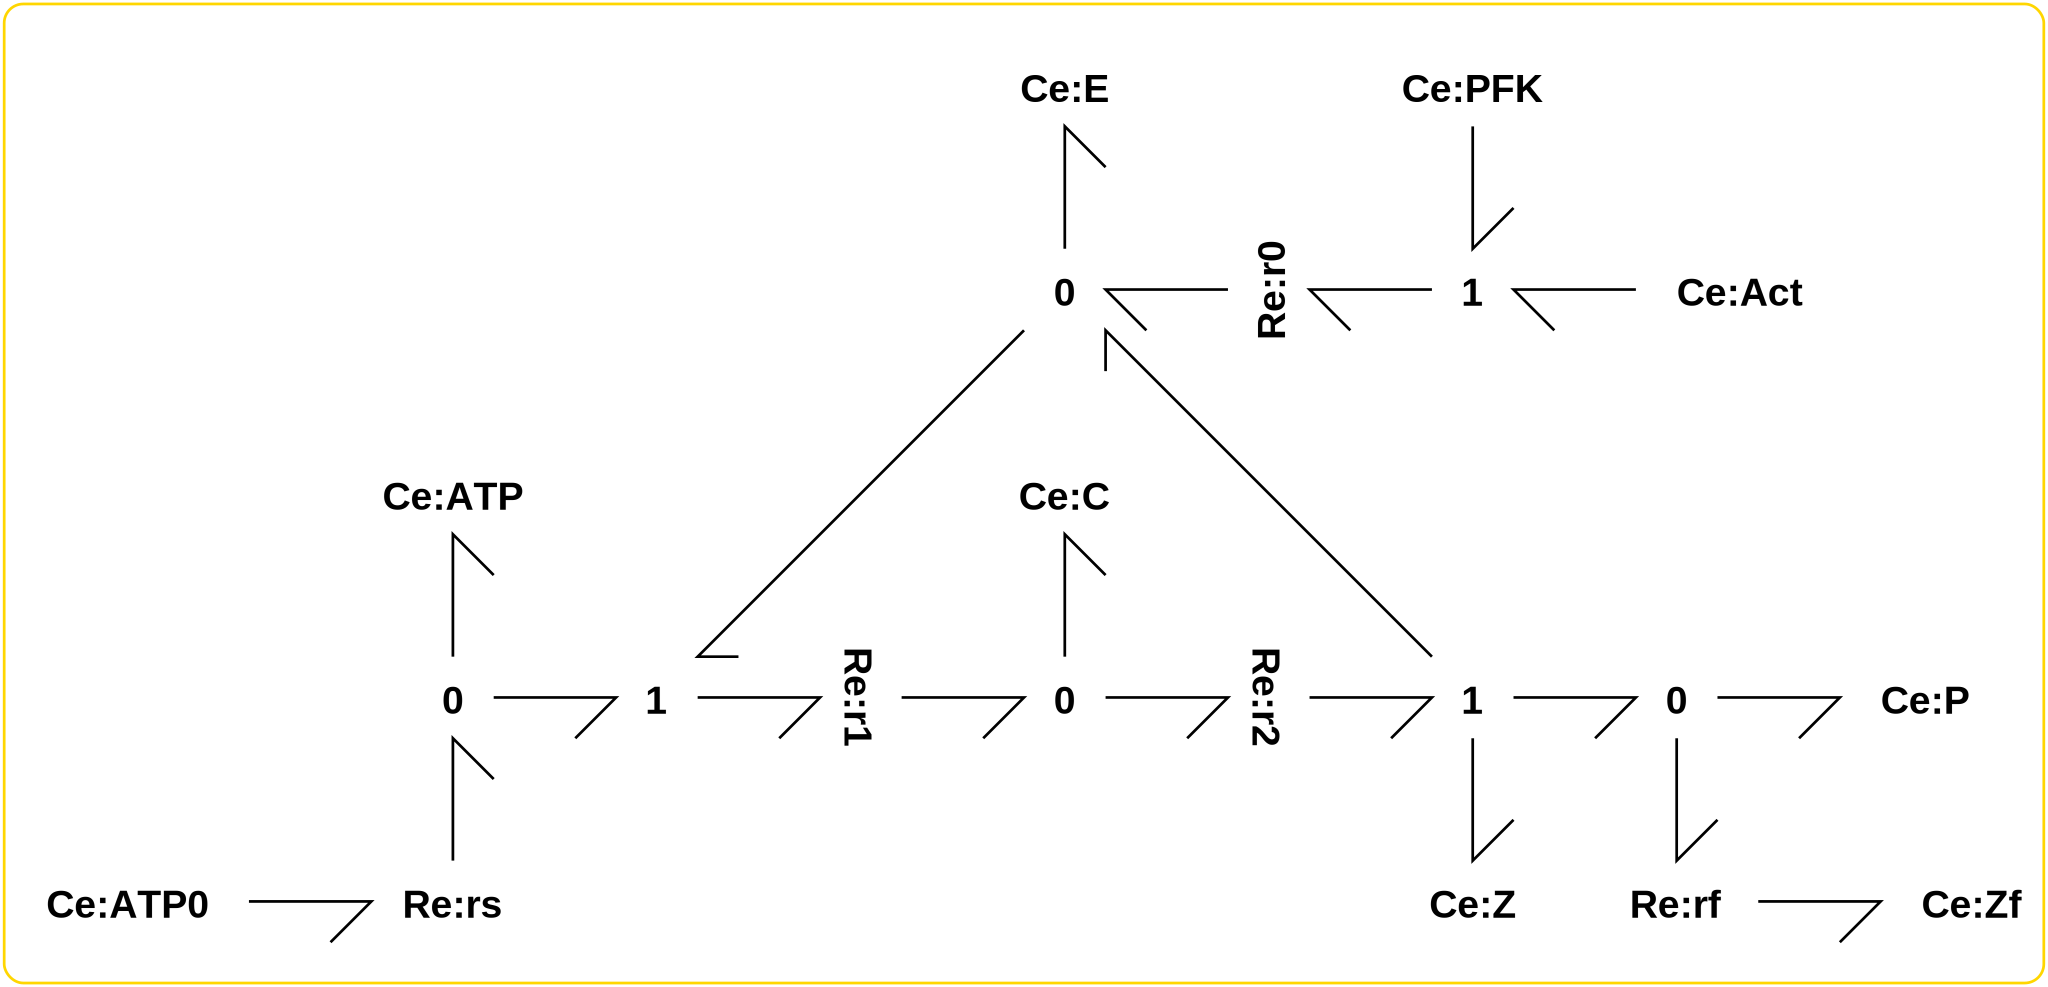

{}


<module 'Selkov_abg' from '/home/peterg/WORK/Research/SystemsBiology/Notes/2024/Oscillation/Selkov_abg.py'>

['ATP', 'ATP0', 'Act', 'C', 'E', 'P', 'PFK', 'Z', 'Zf']


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

\begin{align}
\ch{Act + PFK & <> [ r0 ] E }\\
\ch{ATP + E & <> [ r1 ] C }\\
\ch{C & <> [ r2 ] E + P + Z }\\
\ch{P & <> [ rf ] Zf }\\
\ch{ATP0 & <> [ rs ] ATP }
\end{align}

\begin{align}
v_{r0} &= \kappa_{r0} \left(K_{Act} K_{PFK} x_{Act} x_{PFK} - K_{E} x_{E}\right)\\
v_{r1} &= \kappa_{r1} \left(K_{ATP} K_{E} x_{ATP} x_{E} - K_{C} x_{C}\right)\\
v_{r2} &= \kappa_{r2} \left(K_{C} x_{C} - K_{E} K_{P} K_{Z} x_{E} x_{P} x_{Z}\right)\\
v_{rf} &= \kappa_{rf} \left(K_{P} x_{P} - K_{Zf} x_{Zf}\right)\\
v_{rs} &= \kappa_{rs} \left(- K_{ATP} x_{ATP} + K_{ATP0} x_{ATP0}\right)
\end{align}



In [31]:
subTF = {}    
V_ss = {}
for subname in ['decr_abg','decrc_abg','decrc3_abg','decrc4_abg',
                'dECR_abg','dECRc_abg','ActInh_abg','Selkov_abg']:
    
    svg = subname+'.svg'
    print('\n\nUsing',svg)
    disp.SVG(svg)

    sbg.model(svg,convertCe=True,convertR=True,quiet=quiet)
    exec(f'import {subname} as sys_abg')
    imp.reload(sys_abg)

    s = st.stoich(sys_abg.model(),quiet=quiet)
    species = s['species']
    print(species)
    disp.Latex(st.sprintrl(s,all=True))
    disp.Latex(st.sprintvl(s))
    print(st.sprintrl(s,all=True,chemformula=True))
    print(st.sprintvl(s))
    
    if subname not in ['ActInh_abg','Selkov_abg']:   
        parameter={} 
        chemostats = ['P','E','A','Zf']     
        sc = st.statify(copy.deepcopy(s),chemostats=chemostats)
        parameter['K_A'] = 1 
        # parameter['K_Z'] = 
        parameter['K_Zf'] = 1e-6 
        parameter['kappa_rf'] = 10

        if subname in ['dECR_abg','dECRc_abg']:
            parameter['kappa_r1'] =  parameter['kappa_r2'] = 2*1000
        else:
            parameter['kappa_r'] = 1000
        
        Sys = st.lin(s,sc,outvar='dX',parameter=parameter)
        for inp in ['E','P']:
            for outp in ['E','P']:
                sys = extractSysdX(Sys,s,inp,chemostats,outp)
                print(inp, ' - ', outp)
                con.tf(sys)
        
        chemostats = ['A','Zf','P']
        sc = st.statify(copy.deepcopy(s),chemostats=chemostats)
         
        K = np.linspace(0.1,2)
        e0 = 0.1
        V_ss[subname] = []
        x0 = np.ones(s['n_X'])
        for K_A in K:
            parameter['K_A'] = K_A
            if subname in ['dECR_abg','dECRc_abg']:
                x0[species.index('E')] = x0[species.index('C')] =e0/2
                parameter['kappa_r1']= 1e2
            else:
                x0[species.index('E')] = e0
            x_ss,v_ss = SteadyState(s,sc,parameter,x0,returnAll=False)
            V_ss[subname].append(v_ss)
            
    if subname in ['ActInh_abg']:
        chemostats = ['E','E0','Inh','Act']
        sc = st.statify(copy.deepcopy(s),chemostats=chemostats)
        parameter = {}
        Sys = st.lin(s,sc,outvar='dX',parameter=parameter)
        for inp in ['Inh','E']:
            for outp in ['Inh','E']:
                sys = extractSysdX(Sys,s,inp,chemostats,outp)
                print(inp, ' - ', outp)
                con.tf(sys)

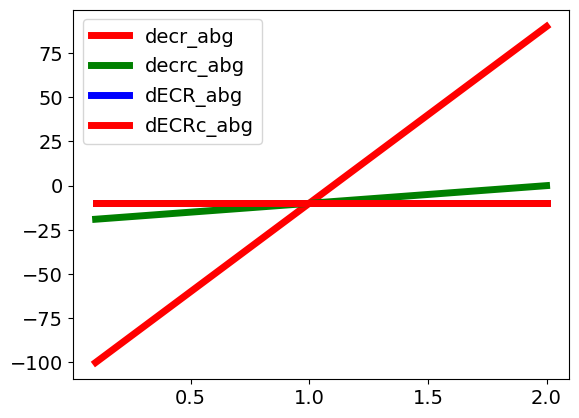

In [32]:
for subname in  ['decr_abg', 'decrc_abg', 'dECR_abg','dECRc_abg']:     
    plt.plot(K,V_ss[subname],label=subname)       
plt.legend()    

# Feedback system

Using ToyFB_abg.svg
Creating subsystem: ActInh:fb
Creating subsystem: decrc:decr1
Creating subsystem: decrc:decr2
Creating subsystem: decrc:decr3
{}


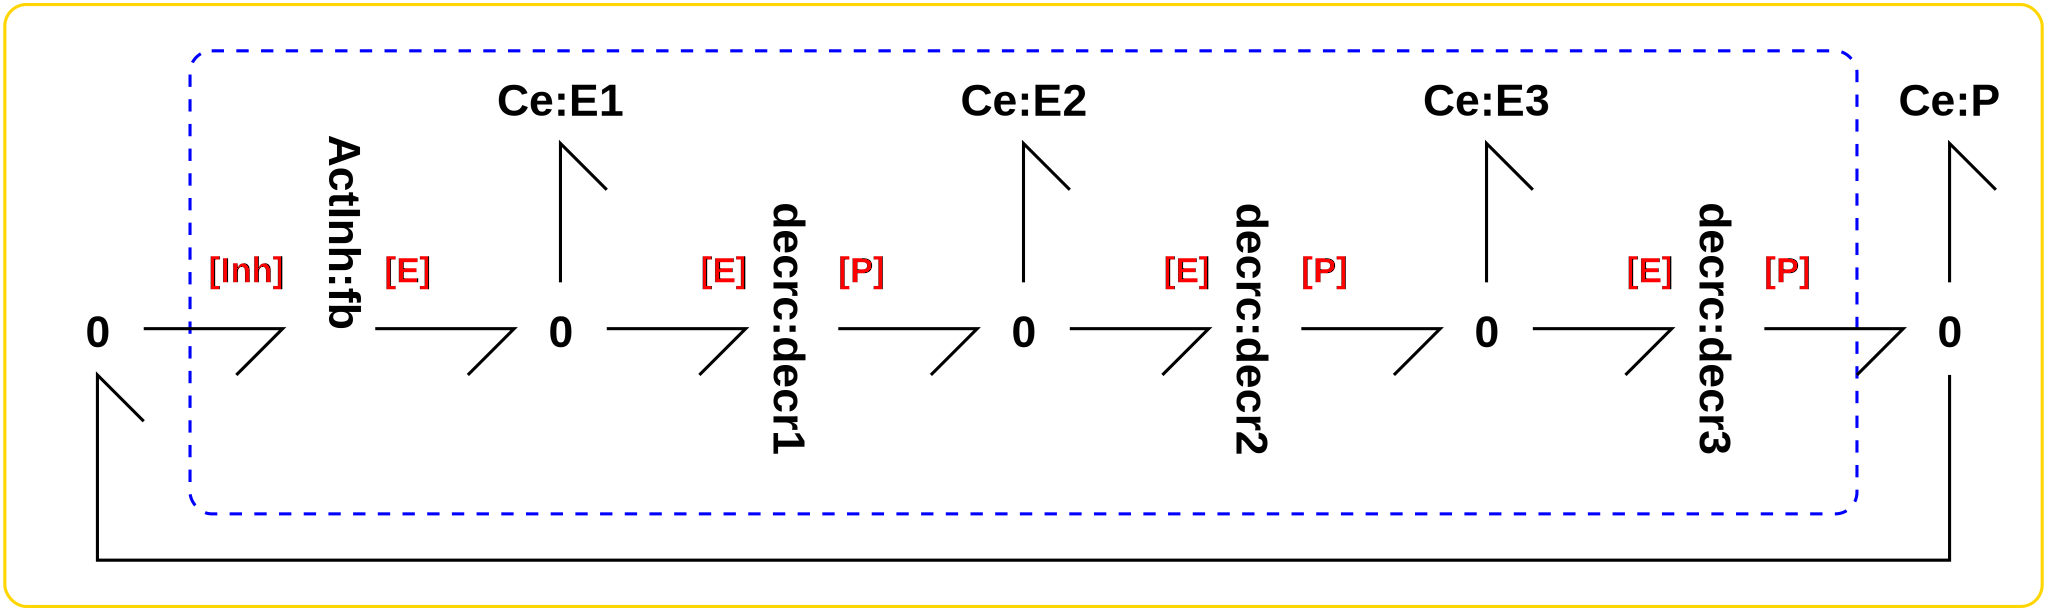

<module 'ToyFB_abg' from '/home/peterg/WORK/Research/SystemsBiology/Notes/2024/Oscillation/ToyFB_abg.py'>

In [33]:
name = SystemName+'FB_abg'
svg = name+'.svg'
print('Using',svg)
sbg.model(svg,convertCe=True,convertR=True,quiet=quiet)
disp.SVG(svg)

exec(f'import {name} as sys_abg')
imp.reload(sys_abg)


In [34]:
## Set up system
# v_ATP=0.6
chemostats,parameter,InpVar,OutpVar,T,T_long,n_red = SetAll(SystemName,Config='Open',quiet=False)
chemostats_open = chemostats
# print(parameter)

Setting feedback loop with configuration Open


## Stoichiometry

In [35]:
s,sc = stoichiometry(sys_abg.model(),chemostats=chemostats)
species = s['species']
species_open = copy.copy(species)
reaction = s['reaction']
print(species)
print()
print(reaction)
print()
print(parameter)   

if SaveData:
    StoichData = {}
    StoichData['s'] = s
    StoichData['sc'] = sc
    StoichData['parameter'] = parameter
    SavedData['Stoich'] = StoichData



['fb_Act', 'fb_E0', 'E1', 'E2', 'E3', 'P', 'decr1_A', 'decr1_Zf', 'decr2_A', 'decr2_Zf', 'decr3_A', 'decr3_Zf']

['fb_r', 'decr1_r', 'decr1_rf', 'decr2_r', 'decr2_rf', 'decr3_r', 'decr3_rf']

{'K_fb_Act': 1, 'K_decr1_Zf': 1e-06, 'kappa_decr1_r': 1.0, 'kappa_decr1_rf': 10, 'K_decr1_A': 100.0, 'K_E1': 1, 'K_decr2_Zf': 1e-06, 'kappa_decr2_r': 1.0, 'kappa_decr2_rf': 10, 'K_decr2_A': 100.0, 'K_E2': 1, 'K_decr3_Zf': 1e-06, 'kappa_decr3_r': 1.0, 'kappa_decr3_rf': 10, 'K_decr3_A': 100.0, 'K_E3': 1}


In [36]:
## Reactions and properties
disp.Latex(st.sprintrl(s,all=True,chemformula=False))
# Properties(s,sc)

print('Pools:')
disp.Latex(st.sprintml(s))
print('Paths')
print(st.sprintp(sc))

<IPython.core.display.Latex object>

Pools:


<IPython.core.display.Latex object>

Paths
4 pathways
0:  + decr1_r + decr1_rf
1:  + decr2_r + decr2_rf
2:  + decr3_r
3:  + decr3_rf



# Open-loop analysis

In [37]:
def OpenLoop(OutpVar='P',InpVar='fb_Act'):
    ## Steady-state analysis

    x0 = np.ones(s['n_X'])
    x_ss,SS = findSteadyState(s,sc,parameter,x0,OutpVar=OutpVar,returnAll=True)
    printSS(s,x_ss,parameter)

    ## Linearise
    TF,Sys_OL = Lin(s,sc,parameter=parameter,x_ss=x_ss,outvar='dX',Inp=[InpVar,OutpVar], Outp=[OutpVar])

    ## Loop gain
    Lname = OutpVar+'_'+OutpVar
    L0 = -TF[Lname]
    L = IntegrateTF(L0)
    L0_sys = -Sys_OL[Lname]

    ## Forward gain
    F = TF[InpVar+'_'+OutpVar]
    
    return L,L0,L0_sys,F,x_ss,SS


L,L0,L0_sys,F,x_ss,SS = OpenLoop(OutpVar=OutpVar,InpVar=InpVar)
x_ss_open = x_ss
# print(x_ss)


## Steady state
x_{E1} &= 0.17\\
x_{E2} &= 0.28\\
x_{E3} &= 0.79\\
x_{P} &= 5.9\\

## Parameters
K_decr1_Zf & 1e-06\\
kappa_decr1_rf & 10\\
K_decr1_A & 1e+02\\
K_decr2_Zf & 1e-06\\
kappa_decr2_rf & 10\\
K_decr2_A & 1e+02\\
K_decr3_Zf & 1e-06\\
kappa_decr3_rf & 10\\
K_decr3_A & 1e+02\\
0 states have been removed from the model
0 states have been removed from the model


In [38]:
print('L0:',L0)
print(f'Gain: {con.dcgain(L0):.2f}')

print('L:',L)
print(f'Gain: {con.dcgain(L):.2f}')

L0: 
10.8 (s + (0.4024-14.08j)) (s + (0.4024+14.08j)) (s + 25.15)
------------------------------------------------------------
            (s + 5.936) (s + 10.03) (s + 10.08)

Gain: 89.77
L: 
10.8 (s + (0.4024-14.08j)) (s + (0.4024+14.08j)) (s + 25.15)
------------------------------------------------------------
          (s) (s + 5.936) (s + 10.03) (s + 10.08)

Gain: inf


In [39]:
# print(L0)
sysL0 = con.ss(L0)
sysL0_r = balred(sysL0,n_red)
L0_r = con.tf(sysL0_r)

print('L0_r:',L0_r)
print(f'Gain: {con.dcgain(L0_r):.2f}')
print(f'Poles: {con.poles(L0_r)}')

L0_r: 
10.8 (s + (1.934-14.22j)) (s + (1.934+14.22j))
----------------------------------------------
  (s + (4.006-3.068j)) (s + (4.006+3.068j))

Gain: 87.35
Poles: [-4.00558944+3.06802235j -4.00558944-3.06802235j]


In [40]:
print('F:',F)
print(f'Gain: {con.dcgain(F):.2f}')


F: 
(s - (26.16+56.63j)) (s - (26.16-56.63j)) (s + 72.44)
-----------------------------------------------------
         (s + 5.936) (s + 10.03) (s + 10.08)

Gain: 469.79


In [41]:
print('Poles', (con.poles(L)))
print('Zeros', (con.zeros(L)))

Poles [-10.08007675+0.j -10.02837804+0.j  -5.93620394+0.j   0.        +0.j]
Zeros [-25.14726161 +0.j          -0.40240029+14.07807795j
  -0.40240029-14.07807795j]


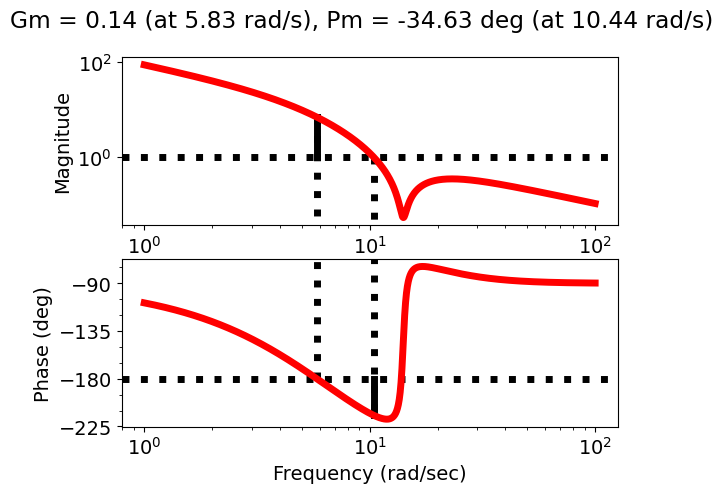

In [42]:
mag,phase,omega=con.bode_plot(L,margins=True)
SaveFig(SysName,'Bode')

2

(-2.0, 1.0)

(-2.0, 2.0)

Text(0.5, 0, 'Re $L$')

Text(0, 0.5, 'Im $L$')

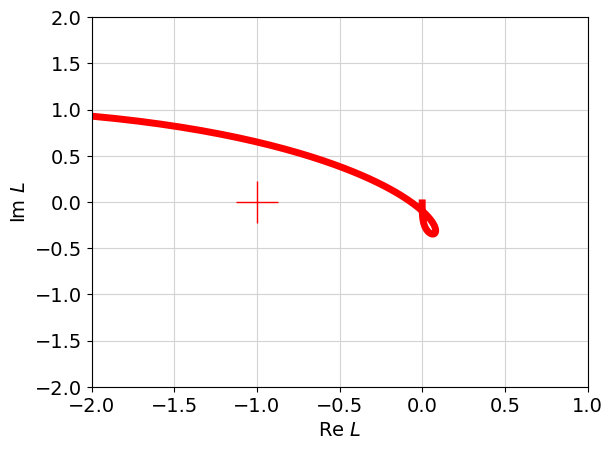

In [43]:
# mag,phase,omega=con.nyquist_plot([L])
con.nyquist_plot(L,mirror_style=False)
plt.xlim(-2,1)
plt.ylim(-2,2)
plt.xlabel('Re $L$')
plt.ylabel('Im $L$')
SaveFig(SysName,'Nyquist')

In [44]:
gm, pm, wcg, wcp = con.margin(L)
print(gm, pm, wcg, wcp)
freq = wcg/(2*np.pi)
print(f'Frequency: {freq:0.2f}Hz, Period: {1/freq:0.2f}sec')
print(f'$\\theta_{{pm}} = {int(round(pm))}^\\circ$')
print(f'$\\omega_{{pm}} = \\SI{{{wcp:.2f}}}{{\\radian\\per\\second}}$')


0.14287800387041347 -34.63384689966517 5.829034641551713 10.444107808159126
Frequency: 0.93Hz, Period: 1.08sec
$\theta_{pm} = -35^\circ$
$\omega_{pm} = \SI{10.44}{\radian\per\second}$


## Derive linear closed-loop response

- the closed-loop system is derived from the open loop system L(s)
- the input corresponds to an additive input to the product input $f_P$.
    - this is equivalent to the integrator $1/s$ in the forward path and $L_0(s)$ in the feedback path
    - the feedback() function from the control toolbox is used.
    - a unit impulse on this input is equivalent to a unit perturbation in the *initial* product state $x_P(0)$.  

In [45]:
## Simple integrator 1/s
Integrator = con.tf(1,[1,0])

## Full model
CLL = con.feedback(Integrator,L0)
# CLL = con.feedback(con.series(Integrator,L0))
# CLL = con.feedback(L)
CLL_tf = con.tf(CLL)
print(CLL_tf)
print(con.poles(CLL_tf))

## Reduced model
CLL_r = con.feedback(Integrator,L0_r)
CLL_r_tf = con.tf(CLL_r)
print(CLL_r_tf)
print(con.poles(CLL_r_tf))


                        (s + 5.936) (s + 10.03) (s + 10.08)
-----------------------------------------------------------------------------------
(s - (1.326+10.32j)) (s - (1.326-10.32j)) (s + (19.75-10.35j)) (s + (19.75+10.35j))

[-19.74856549+10.35123185j -19.74856549-10.35123185j
   1.3264659 +10.3244805j    1.3264659 -10.3244805j ]

       (s + (4.006-3.068j)) (s + (4.006+3.068j))
-------------------------------------------------------
(s - (0.9639+10.31j)) (s - (0.9639-10.31j)) (s + 20.74)

[-20.73858697 +0.j           0.96393381+10.30975207j
   0.96393381-10.30975207j]


# Investigate parameter dependencies

In [46]:
if ParametricVariation:
    if SystemName in ['Toy','Toy1','Toycc','ToyTwo','ToyTwo3','ToyTwo4','ToyTwo4']:
        RR = np.linspace(1,30,50)
        xlabel = r'$\kappa_{rf}$'
        ACT = [0.2,1,5]
        ActName = '$K_{Act}$'
    elif SystemName in ['Goodwin']:
        RR = np.linspace(1,10,10)
        xlabel = r'$\kappa_{rf}$'
        ACT = [0.5,1,10]
        ActName = '$K_{Act}$'
    elif SystemName in ['Selkov','Selkov1','Selkov3']:
        RR = np.linspace(0.15,1,50)
        xlabel = '$v_{ATP}$'
        ACT = [8,10,12] # used as kappa_rf
        ActName = '$\kappa_{rf}$'
    ylabel = 'Pole'
    
    # RR = []
    # ACT = []
    
    PPM = {}
    XX_P_ss = {}
    FREQ = {}
    POLES = {}
    MAXrpole = {}
    MAXipole= {}
    for Act in ACT:
        Freq = []
        PM = []
        Maxrpole = []
        Maxipole = []
        X_P_ss = []
        for rr in RR:
            print(f'rr = {rr:0.2f}')
            if SystemName in ['Toy','Toy1']:
                parameter = SetParameterToy(N=3,kappa_rf=rr,K_Act=Act)
            elif SystemName in ['ToyTwo','ToyTwo3','ToyTwo4']:
                parameter = SetParameterToy(N=2,kappa_rf=rr,K_Act=Act)
            elif SystemName in ['Goodwin']:
                parameter = SetParameterGoodwin(kappa_rf=rr,K_Act=Act)
            elif SystemName in ['Selkov','Selkov1','Selkov3']:
                parameter = SetParameterSelkov(v_ATP=rr,kappa_rf=Act)
            else: 
                print('SystemName', SystemName, 'not known')
            LL,LL0,LL0_sys,FF,xx_ss,SS = OpenLoop(OutpVar=OutpVar,InpVar=InpVar)
 
            ## Closed-loop properties
            Integrator = con.tf(1,[1,0])
            CL = con.feedback(Integrator,LL0)
        #         CL = con.minreal(CL)
            gmi, pmi, wcgi, wcpi = con.margin(LL)
            freq = wcpi/(2*np.pi)
            Freq.append(freq)
            PM.append(pmi)
            poles = con.poles(CL)
            if rr == min(RR):
                Poles = poles
            else:
                Poles = np.vstack((Poles,poles))
            
        #         print(poles)
            maxrpole = max(np.real(poles))
        #         print(f'Max real pole = {maxpole:0.2f}')
            maxipole = max(np.imag(poles))
            Maxrpole.append(maxrpole)
            Maxipole.append(maxipole)
            
            ## Steady-state properties
            x_P_ss = SS['X'][species.index('P')]
            X_P_ss.append(x_P_ss)
    
            
        PPM[Act] = PM
        XX_P_ss[Act] = X_P_ss
        FREQ[Act] = Freq
        POLES[Act] = Poles
        MAXrpole[Act] = Maxrpole
        MAXipole[Act] = Maxipole

In [47]:
if ParametricVariation:
    ## CL poles
    for Act in ACT:
        plt.plot(RR,MAXrpole[Act],label=f'real: {ActName} = {Act}')
        plt.plot(RR,MAXipole[Act],label=f'imag: {ActName} = {Act}')
    plt.grid()
    plt.legend()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    SaveFig(SysName,'RePole')

In [48]:
if ParametricVariation:
    ## CL poles - root -locus
    for Act in ACT:
        Poles = POLES[Act]
        plt.plot(np.real(Poles),np.imag(Poles),label=f'{ActName} = {Act}')
    if SystemName in ['Toy']:
        plt.xlim(-1,5)
    else:
        plt.xlim(-4,4)
    plt.ylim(bottom=0)
    plt.grid()
    # plt.legend()
    plt.xlabel('Real')
    plt.ylabel('Imag')
    SaveFig(SysName,'RL')

In [49]:
if ParametricVariation:
    ## Steady states
    for Act in ACT:
        plt.semilogy(RR,XX_P_ss[Act],label=f'{ActName} = {Act}')
    plt.grid()
    plt.legend()
    plt.xlabel(xlabel)
    plt.ylabel(r'$\bar{x}_P$')
    SaveFig(SysName,'Pss')

In [50]:
if ParametricVariation:
    ## Phase margin
    for Act in ACT:
        plt.plot(RR,PPM[Act],label=f'{ActName} = {Act}')
    plt.grid()
    plt.legend()
    plt.xlabel(xlabel)
    plt.ylabel('$\phi_m^\circ$')
    SaveFig(SysName,'PM')

In [51]:
if ParametricVariation:
    ## Phase margin frequncy
    for Act in ACT:
        plt.plot(RR,FREQ[Act],label=f'{ActName} = {Act}')
    plt.grid()
    plt.legend()
    plt.xlabel(xlabel)
    plt.ylabel('$F_m$ Hz')
    SaveFig(SysName,'Fm')

# Closed-loop analysis

- The linearised closed-loop system is obtained by linearising the non-linear system from the bond graph
- the transfer function is from the activation (Act) to the product (P)
- the transfer function is compared with that deduced from the loop gain L(s)
    - the denominators are the same
    - the numerators are different as the inputs are different   

In [52]:
## Stoichiometry 
chemostats,parameter,InpVar,OutpVar,T,T_long,n_red = SetAll(SystemName,Config='Closed',quiet=False)
s,sc = stoichiometry(sys_abg.model(),chemostats=chemostats)


## Linearise
print(InpVar)
X_ss = copy.copy(x_ss)
TF,Sys = Lin(s,sc,parameter=parameter,x_ss=X_ss,outvar='dX',Inp=[InpVar], Outp=['P'])

## Extract closed-loop transfer-function
CL0 = TF[InpVar+'_P']
print(CL0)
CL = IntegrateTF(CL0,crite=0.1)
print(CL)

#     return CL,s,sc
print(chemostats)

Setting feedback loop with configuration Closed
fb_Act
0 states have been removed from the model

       (s - (26.16+56.63j)) (s - (26.16-56.63j)) (s + 4.22e-15) (s + 72.44)
-----------------------------------------------------------------------------------
(s - (1.326+10.32j)) (s - (1.326-10.32j)) (s + (19.75-10.35j)) (s + (19.75+10.35j))


               (s - (26.16+56.63j)) (s - (26.16-56.63j)) (s + 72.44)
-----------------------------------------------------------------------------------
(s - (1.326+10.32j)) (s - (1.326-10.32j)) (s + (19.75-10.35j)) (s + (19.75+10.35j))

['fb_Act', 'fb_E0', 'decr1_A', 'decr1_Zf', 'decr2_A', 'decr2_Zf', 'decr3_A', 'decr3_Zf']


In [53]:
## Reactions and properties
disp.Latex(st.sprintrl(s,all=True,chemformula=False))
# Properties(s,sc)

print('Pools:')
disp.Latex(st.sprintml(s))
print('Paths')
print(st.sprintp(sc))

<IPython.core.display.Latex object>

Pools:


<IPython.core.display.Latex object>

Paths
3 pathways
0:  + decr1_r + decr1_rf
1:  + decr2_r + decr2_rf
2:  + decr3_r + decr3_rf



## Compare two versions of closed-loop TF

In [54]:
# CL,s,sc = ClosedLoopTF(SystemName,sys_abg.model(),InpVar,parameter,x_ss)
print('CLL:',CLL)
print('CL:',CL)
print(f'Gain: {con.dcgain(CL):.2f}')

CLL: 
                        (s + 5.936) (s + 10.03) (s + 10.08)
-----------------------------------------------------------------------------------
(s - (1.326+10.32j)) (s - (1.326-10.32j)) (s + (19.75-10.35j)) (s + (19.75+10.35j))

CL: 
               (s - (26.16+56.63j)) (s - (26.16-56.63j)) (s + 72.44)
-----------------------------------------------------------------------------------
(s - (1.326+10.32j)) (s - (1.326-10.32j)) (s + (19.75-10.35j)) (s + (19.75+10.35j))

Gain: 5.23


In [55]:
print('Poles:', (con.poles(CL)))

Poles: [-19.74856549+10.35123185j -19.74856549-10.35123185j
   1.3264659 +10.3244805j    1.3264659 -10.3244805j ]


In [56]:
CLr = balred(con.ss(CL),3)
print(con.tf(CLr))
poles = con.poles(CLr)
print('Poles:', poles)


   3.994 (s - (30.61+39.16j)) (s - (30.61-39.16j))
-----------------------------------------------------
(s - (1.326+10.32j)) (s - (1.326-10.32j)) (s + 16.97)

Poles: [  1.3264659 +10.3244805j   1.3264659 -10.3244805j
 -16.96616984 +0.j       ]


In [57]:
print(abs(poles[0]))
Omega = abs(np.imag(poles[0]))
Freq = Omega/(2*np.pi)
print(Freq,1/Freq)

10.40934241269315
1.6431921071431235 0.6085715697226747


## Linear time response

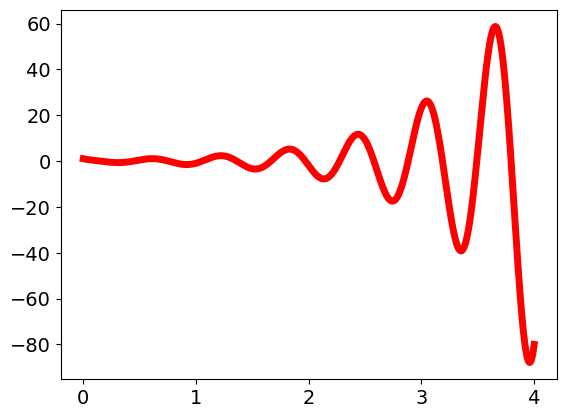

In [58]:

# y_cl = impulse_response(CL,T=T)
y_cll = impulse_response(CLL,T=T)
#y_cll_r = impulse_response(CLL_r,T=T)


In [59]:
# print(CL.state_labels)

## Non-linear simulation
- the non-linear simulation has the initial state the same as the steady state *except* that the intial value $x_P(0)$ of the product state $x_P$ is perturbed by pert.
- the trajectory $x_P(t)$ from the nonlinear system is compared with the impulse response of the linearised system
    - the input to the the linearised system is pert*unit_impulse. 

In [60]:
## Simulate
print(InpVar)
species = s['species']
print(species)
reaction = s['reaction']
X0 = copy.copy(x_ss)
pert = 1e-2
# X0[species.index(InpVar)] *= 1+pert
X0[species.index('P')] += pert
ndat = st.sim(s,sc=sc,t=T,X0=X0,parameter=parameter,quiet=False)


fb_Act
['fb_Act', 'fb_E0', 'E1', 'E2', 'E3', 'P', 'decr1_A', 'decr1_Zf', 'decr2_A', 'decr2_Zf', 'decr3_A', 'decr3_Zf']
Setting K_fb_Act to 1
Setting K_E1 to 1
Setting K_E2 to 1
Setting K_E3 to 1
Setting K_decr1_A to 100.0
Setting K_decr1_Zf to 1e-06
Setting K_decr2_A to 100.0
Setting K_decr2_Zf to 1e-06
Setting K_decr3_A to 100.0
Setting K_decr3_Zf to 1e-06
Setting kappa_decr1_r to 1.0
Setting kappa_decr1_rf to 10
Setting kappa_decr2_r to 1.0
Setting kappa_decr2_rf to 10
Setting kappa_decr3_r to 1.0
Setting kappa_decr3_rf to 10


Text(0.5, 0, '$t$')

Text(0, 0.5, '$x_{P} - x_{ss}$')

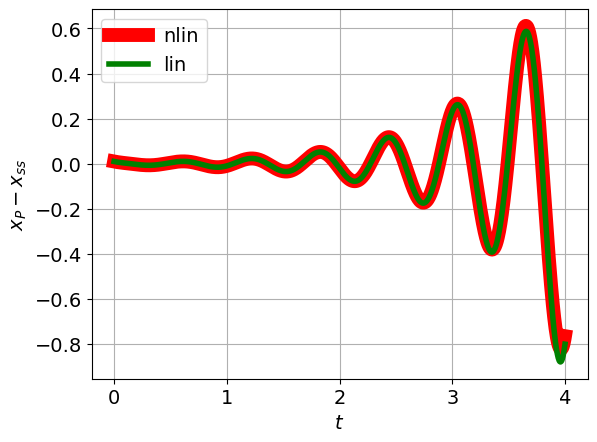

In [61]:
if SystemName in ['Toy','Toy1','Toycc','ToyTwo','ToyTwo3','ToyTwo4','Goodwin']:
    Yname = 'P'
    Xlabel = 't'
    Ylabel = 'P'
elif SystemName in ['Selkov','Selkov1','Selkov3']:
    Yname = 'P'
    Xlabel = 't'
    Ylabel = 'ADP'
else:
    print('System Name',SystemName,'is not known')
    
y_n = (ndat['X'][:,species.index('P')] - x_ss[species.index('P')] )
plt.plot(T,y_n, label='nlin',lw=10)
plt.plot(T,pert*y_cll,label='lin',lw=4)
# plt.plot(T,pert*y_cll_r,label='lin (reduced)',lw=4,ls='dashed')
plt.grid()
plt.legend()
plt.xlabel('$t$')
plt.ylabel('$x_{'+Ylabel+'} - x_{ss}$')
if SysName == 'Selkov3':
    plt.xlim((0,0.1))
    plt.ylim((0,0.1))
SaveFig(SysName,'Simulation')

In [62]:
# st.plot(s,ndat,species=['P'],reaction=[])
# st.plot(s,ndat,species=['E1'],reaction=[])
# st.plot(s,ndat,species=['E2'],reaction=[])
# st.plot(s,ndat,species=['E3'],reaction=[])

In [63]:

ndat = st.sim(s,sc=sc,t=T_long,X0=X0,parameter=parameter,quiet=False)


Setting K_fb_Act to 1
Setting K_E1 to 1
Setting K_E2 to 1
Setting K_E3 to 1
Setting K_decr1_A to 100.0
Setting K_decr1_Zf to 1e-06
Setting K_decr2_A to 100.0
Setting K_decr2_Zf to 1e-06
Setting K_decr3_A to 100.0
Setting K_decr3_Zf to 1e-06
Setting kappa_decr1_r to 1.0
Setting kappa_decr1_rf to 10
Setting kappa_decr2_r to 1.0
Setting kappa_decr2_rf to 10
Setting kappa_decr3_r to 1.0
Setting kappa_decr3_rf to 10


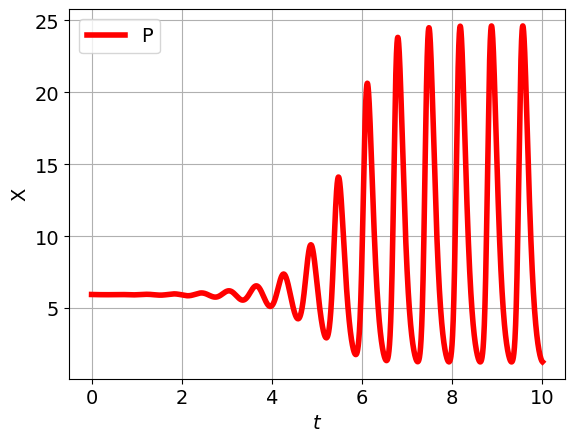

In [64]:
st.plot(s,ndat,species=['P'],reaction=[])
# st.plot(s,ndat,species=['E1'],reaction=[])
# st.plot(s,ndat,species=['E2'],reaction=[])
# st.plot(s,ndat,species=['E3'],reaction=[])

## Phase plane

['fb_Act', 'fb_E0', 'E1', 'E2', 'E3', 'P', 'decr1_A', 'decr1_Zf', 'decr2_A', 'decr2_Zf', 'decr3_A', 'decr3_Zf']


Text(0.5, 0, '$x_{E1}$')

Text(0, 0.5, '$x_{P}$')

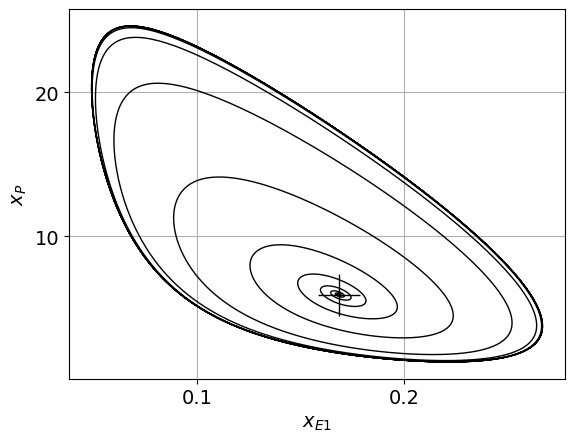

In [65]:
print(species)
if SystemName in ['Toy','Toy1','Toycc','ToyTwo','ToyTwo3','ToyTwo4','Goodwin']:
    Xname = 'E1'
    Yname = 'P'
    Xlabel = Xname
    Ylabel = Yname
elif SystemName in ['Selkov','Selkov1','Selkov3']:
    Xname = 'selkov_ATP'
    Yname = 'P'
    Xlabel = 'ADP'
    Ylabel = 'ATP'
else:
    print('System Name',SystemName,'is not known')
i_X = species.index(Xname)
x_X = ndat['X'][:,i_X]
i_Y = species.index(Yname)
x_Y = ndat['X'][:,i_Y]
plt.plot(x_X,x_Y,lw=1,color='black')

plt.plot(x_ss[i_X],x_ss[i_Y],marker='+',color='black')
plt.locator_params(nbins=4)

# plt.plot(X[:,0],X[:,2])
plt.xlabel(f'$x_{{{Xlabel}}}$')
plt.ylabel(f'$x_{{{Ylabel}}}$')
# plt.xlim(left=0)
# plt.ylim(bottom=0)
plt.grid()


SaveFig(SysName,'PhasePlane')

## Signals at integrator

Text(0.5, 0, '$x_P$')

Text(0, 0.5, '$\\dot{x}_P$')

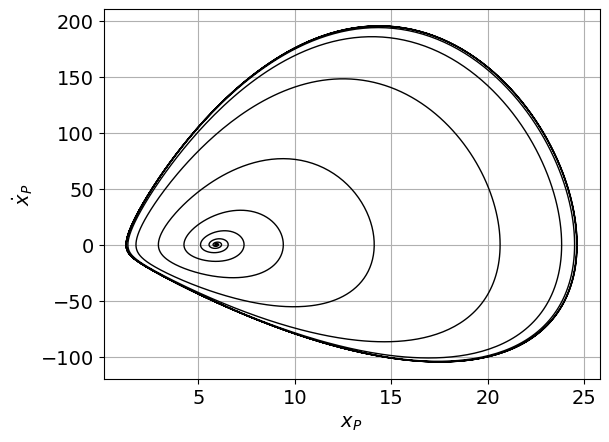

In [66]:
i_P = species.index('P')
x_X = ndat['X'][10:,i_P]
x_Y = ndat['dX'][10:,i_P]
tt = ndat['t'][10:]
plt.plot(x_X,x_Y,lw=1,color='black')
plt.xlabel('$x_P$')
plt.ylabel('$\dot{x}_P$')
# plt.xlim(left=0)
# plt.ylim(bottom=0)
plt.grid()

SaveFig(SysName,'PhasePlaneP')

4491


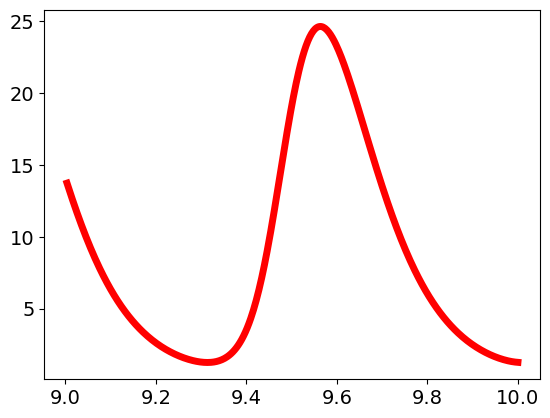

In [67]:
i0 = int(0.9*len(tt))
print(i0)
plt.plot(tt[i0:],x_X[i0:])

## Period

Text(0.5, 0, '$t$')

Text(0, 0.5, '$T$')

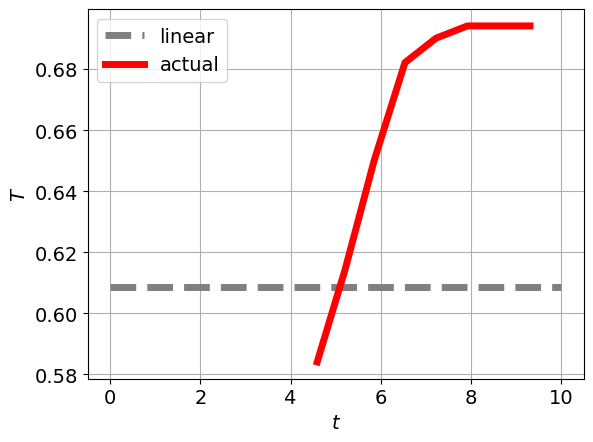

In [68]:
x_Y_ss = x_ss[i_Y]
# print(x_Y_ss)
i_zc = zero_crossings(x_Y-x_Y_ss)
t = ndat['t']
t_zc = t[i_zc]
T_zc = np.diff(t_zc)

plt.hlines([1/Freq],min(t),max(t),ls='dashed',color='grey',label='linear')
plt.plot(t_zc[1:],T_zc, label='actual')

plt.grid()
plt.legend()
plt.xlabel('$t$')
plt.ylabel('$T$')
SaveFig(SysName,'Period')

# print(zc)
# print(1/Freq)


# Power

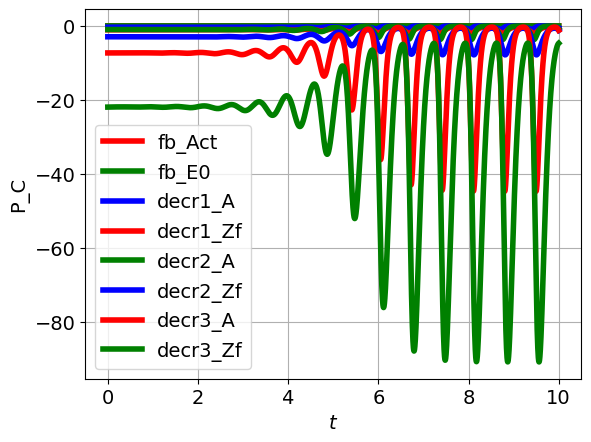

In [69]:
st.plot(s,ndat,plotPower=True,species=chemostats,reaction=[])

In [70]:
# st.plot(s,ndat,plotPower=True,species=[],reaction=['decr3_r','decr3_rf'])

## Power

In [71]:
P_Re = ndat['P_Re']
P_C = -ndat['P_C']
i_chemo = []
for chemo in chemostats:
    i_chemo.append(species.index(chemo))

free = list(set(species)-set(chemostats))
print(free)
i_free = []
for fr in free:
    i_free.append(species.index(fr))
    
P_chemo = P_C[:,i_chemo]
P_free = P_C[:,i_free]

## Total power
PP_Re = np.sum(P_Re,axis=1)
PP_C = np.sum(P_C,axis=1)
PP_chemo = np.sum(P_chemo,axis=1)
PP_free = np.sum(P_free,axis=1)


['E2', 'E1', 'E3', 'P']


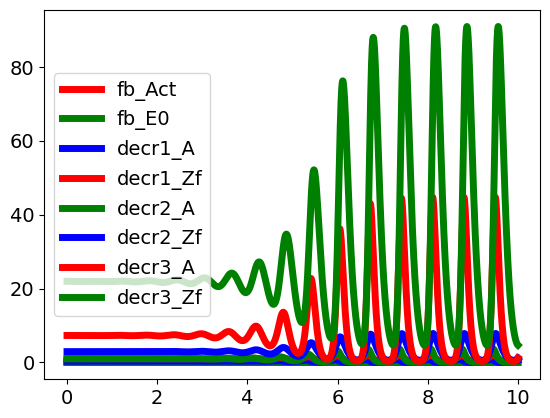

In [72]:
t = ndat['t']
plt.plot(t,P_chemo)
plt.legend(chemostats,loc='center left')

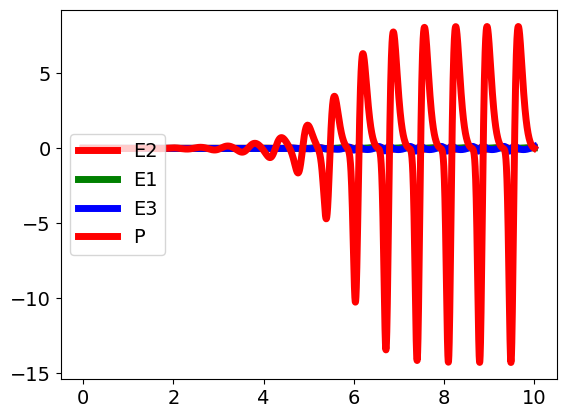

In [73]:
t = ndat['t']
plt.plot(t,P_free)
plt.legend(free,loc='center left')

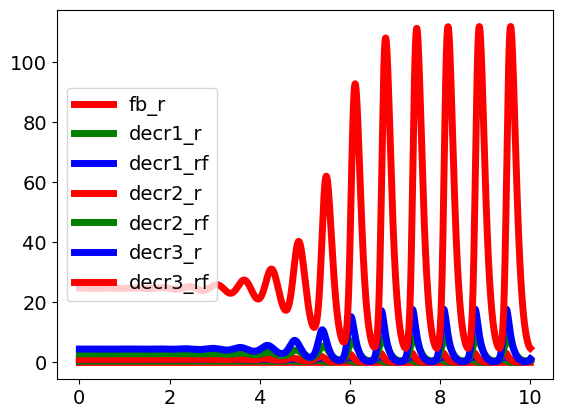

In [74]:
t = ndat['t']
plt.plot(t,P_Re)
plt.legend(reaction,loc='center left')

Text(0.5, 0, '$t$')

Text(0, 0.5, '$p$')

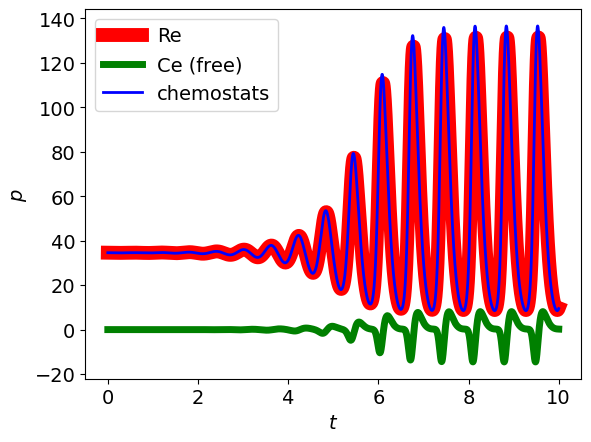

In [75]:
t = ndat['t']
plt.plot(t,PP_Re,label='Re',lw=10)
plt.plot(t,PP_free,label='Ce (free)',lw=5)
plt.plot(t,PP_chemo,label='chemostats',lw=2)
plt.legend()
plt.xlabel('$t$')
plt.ylabel('$p$')
SaveFig(SysName,'Power')

(9.0, 10.5)

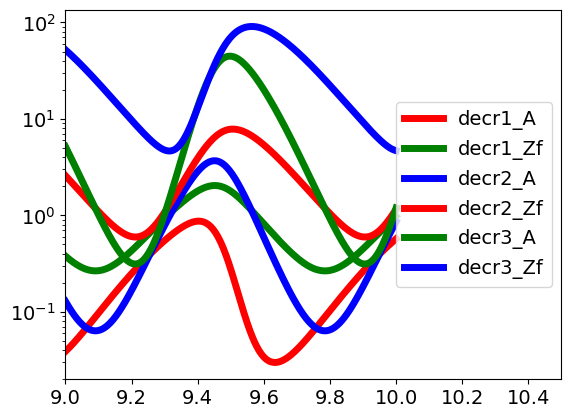

In [76]:
plt.semilogy(t,P_chemo[:,2:])
plt.xlim(left=0.9*max(t))
plt.legend(sc['chemostats'][2:],loc='center right')

# Split-loop analysis

## Model

Using ToySL_abg.svg
Creating subsystem: ActInh:fb
Creating subsystem: decrc:decr1
Creating subsystem: decrc:decr2
Creating subsystem: decrc:decr3
{}


<module 'ToySL_abg' from '/home/peterg/WORK/Research/SystemsBiology/Notes/2024/Oscillation/ToySL_abg.py'>

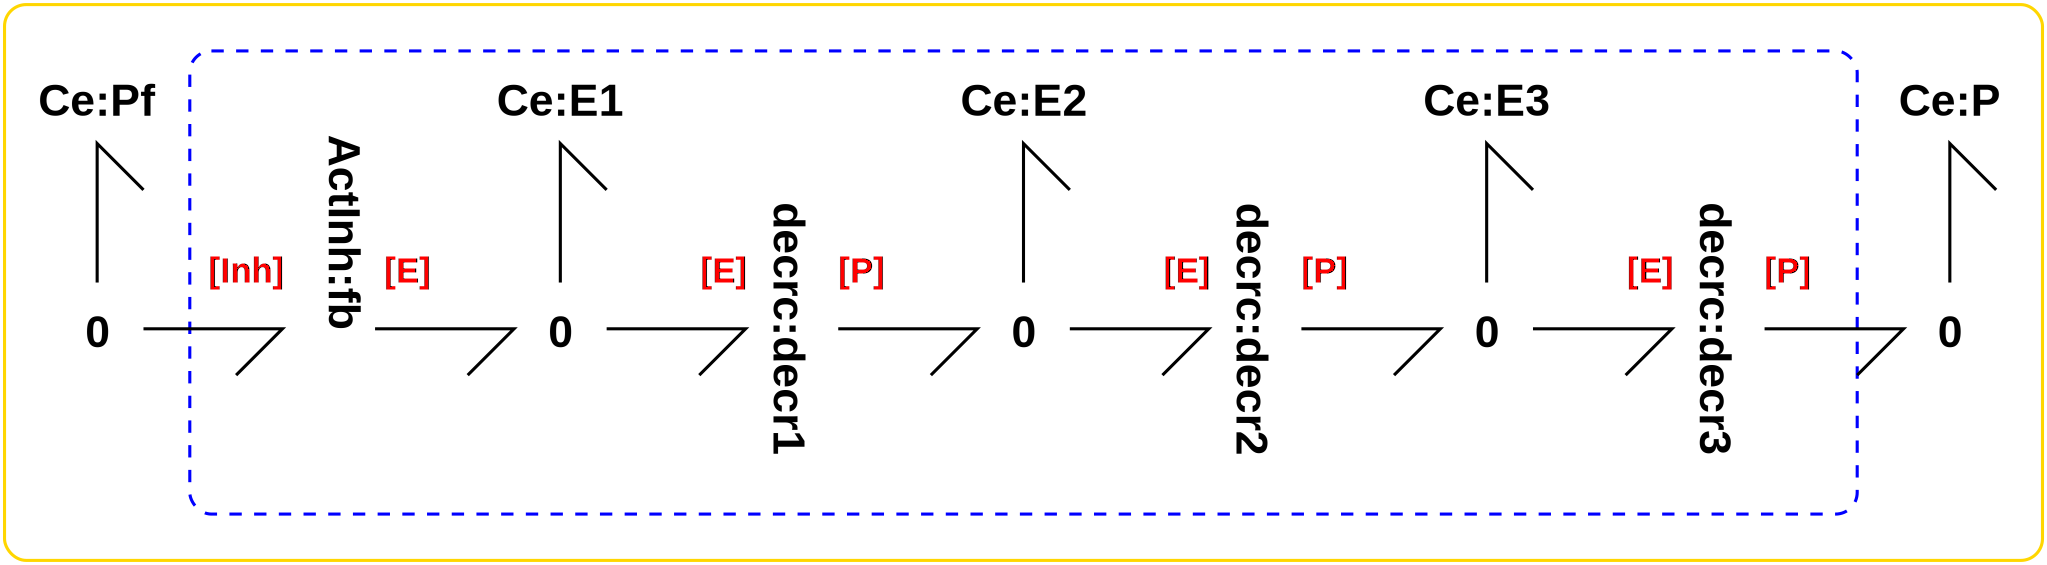

In [77]:
name = SystemName+'SL_abg'
svg = name+'.svg'
print('Using',svg)
sbg.model(svg,convertCe=True,convertR=True,quiet=quiet)
exec(f'import {name} as sys_abg')
imp.reload(sys_abg)
disp.SVG(svg)

SplitVar = 'Pf'

## Stoichiometry

In [78]:
chemostats = SetChemostats(SystemName,Config='SplitLoop',quiet=False)

Setting feedback loop with configuration SplitLoop


In [79]:
print(chemostats)
s,sc = stoichiometry(sys_abg.model(),chemostats=chemostats)
species_sl = s['species']
print(species_sl)

['fb_Act', 'fb_E0', 'Pf', 'P', 'decr1_A', 'decr1_Zf', 'decr2_A', 'decr2_Zf', 'decr3_A', 'decr3_Zf']
['fb_Act', 'fb_E0', 'E1', 'E2', 'E3', 'P', 'Pf', 'decr1_A', 'decr1_Zf', 'decr2_A', 'decr2_Zf', 'decr3_A', 'decr3_Zf']


## Steady-state analysis

In [80]:
## Create the steady state corresponding to open loop with x_inh=x_P:
parameter = SetParameter()
x_sl_ss = np.ones(s['n_X'])
X_ss = copy.copy(x_ss)
for i,spec in enumerate(species):
    x_sl_ss[species_sl.index(spec)] = X_ss[i]
x_sl_ss[species_sl.index(SplitVar)] = X_ss[species.index('P')]

## Linearise

In [81]:
# ttff = con.zpk([-1,-2],[-3,-4,-5],123,display_format='zpk')
# ttff

In [82]:
Inp = [SplitVar,OutpVar]
TF,Sys = Lin(s,sc,parameter=parameter,x_ss=x_sl_ss,outvar='dX',Inp=Inp,Outp=Inp)


2 states have been removed from the model
0 states have been removed from the model
3 states have been removed from the model
3 states have been removed from the model


In [83]:
for name in TF:
    print(name)
    TFr = con.minreal(TF[name])
    TFr
    # zTF = zpk(TF[name])
    # zTF
    print(con.poles(TF[name]))
    

Pf_Pf
0 states have been removed from the model


TransferFunction(array([-0.16845782, -0.        ]), array([1.        , 5.93620394]))

[-5.93620394+0.j]
Pf_P
0 states have been removed from the model


TransferFunction(array([-1.63938517e-12, -4.74893959e+04]), array([  1.        ,  26.04465872, 220.45470876, 600.07198061]))

[-10.08007675+0.j -10.02837804+0.j  -5.93620394+0.j]
P_Pf
0 states have been removed from the model


TransferFunction(array([0.]), array([1.]))

[]
P_P
0 states have been removed from the model


TransferFunction(array([-10.63108265]), array([1.]))

[]


## Active and passive loop gains

In [84]:

LL0 = con.tf(0,1)
L_pas_0 = con.tf(0,1)
for index in TF:
    if not index in ['Pf_P']:
        L_pas_0 = con.minreal(con.parallel(L_pas_0,-TF[index]))

    LL0 = con.minreal(con.parallel(LL0,-TF[index]))
    
# LL0 = con.minreal(LL0)
print('L0') 
LL0

L_act_0 = -TF[SplitVar+'_P']
print('L0_act')
L_act_0

# L_pas_0 = con.minreal(L_pas_0)
print('L0_pas')
L_pas_0

LL = IntegrateTF(LL0)
# LL = con.minreal(LL)
# LL = con.tf(balred(con.ss(LL),3))

print('L') 
L
print('LL')
LL

L_act = IntegrateTF(L_act_0)
print('L_act')
L_act

# L_pas_0 = con.parallel(-TF['P_P'],-TF[SplitVar+'_'+SplitVar])

L_pas = IntegrateTF(L_pas_0)
print('L_pas')
L_pas

# L_pas_P = IntegrateTF(-TF['P_P'])
# print('L_pas_P', L_pas_P)

# L_pas_Inh = IntegrateTF(-TF[SplitVar+'_'+SplitVar])
# print('L_pas_Inh', L_pas_Inh)

0 states have been removed from the model
0 states have been removed from the model
1 states have been removed from the model
0 states have been removed from the model
0 states have been removed from the model
0 states have been removed from the model
0 states have been removed from the model
L0


TransferFunction(array([1.07995405e+01, 2.80270346e+02, 2.36070109e+03, 5.38688107e+04]), array([  1.        ,  26.04465872, 220.45470876, 600.07198061]))

L0_act


TransferFunction(array([1.63938517e-12, 4.74893959e+04]), array([  1.        ,  26.04465872, 220.45470876, 600.07198061]))

L0_pas


TransferFunction(array([10.79954047, 63.10827468]), array([1.        , 5.93620394]))

L


TransferFunction(array([1.07995405e+01, 2.80270346e+02, 2.36070109e+03, 5.38688107e+04]), array([  1.        ,  26.04465872, 220.45470876, 600.07198061,
         0.        ]))

LL


TransferFunction(array([1.07995405e+01, 2.80270346e+02, 2.36070109e+03, 5.38688107e+04]), array([  1.        ,  26.04465872, 220.45470876, 600.07198061,
         0.        ]))

L_act


TransferFunction(array([1.63938517e-12, 4.74893959e+04]), array([  1.        ,  26.04465872, 220.45470876, 600.07198061,
         0.        ]))

L_pas


TransferFunction(array([10.79954047, 63.10827468]), array([1.        , 5.93620394, 0.        ]))

In [85]:
# print(f'Gain L0 = {con.dcgain(L0):.2f}')
# L0_pas_P = TF['P_P']
# K =  parameter['K_decr3_A']*parameter['kappa_decr3_r']
# K_f =  parameter['kappa_decr3_rf']
# print(f'Gain L0_pas_P = {con.dcgain(L0_pas_P):0.2f} ({K_f:0.2f})')

## Bode plots

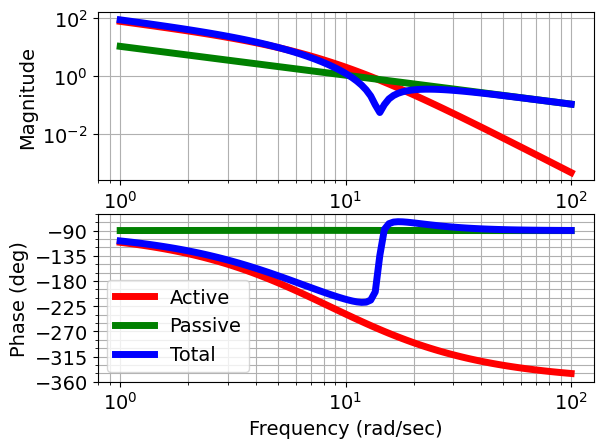

In [86]:
## Bode
L_list = [L_act,L_pas,LL]
omega = np.logspace(0,2,100)
mag,phase,om=con.bode_plot(L_list,omega)
plt.legend(['Active','Passive','Total'])
SaveFig(SysName,'SplitBode')



In [87]:
if SaveData:
    BodeData = {}
    BodeData['L_list'] = L_list
    BodeData['mag'] = mag
    BodeData['phase'] = phase
    BodeData['omega'] = om
    BodeData['wcp'] = wcp
    BodeData['pm'] = pm
   
    SavedData['Bode'] = BodeData
    

## Nichols plots

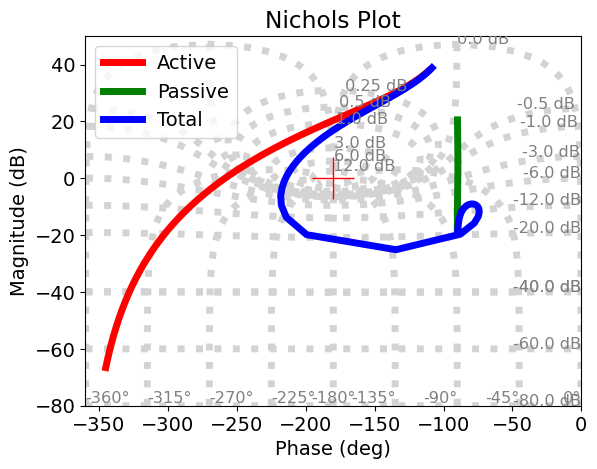

In [88]:
## Nichols
con.nichols_plot(L_list,omega)
plt.legend(['Active','Passive','Total'])
SaveFig(SysName,'SplitNichols')

## Root Locus

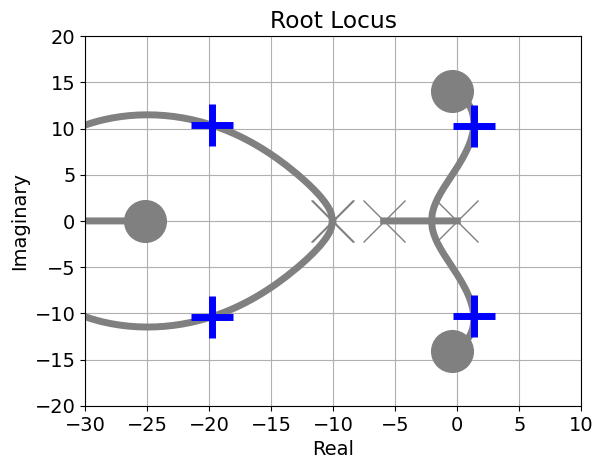

In [89]:
if SystemName in ['Selkov','Selkov1','Selkov3']:
    xlim=(-6,15)
    ylim=(-10,10)
else:
    xlim=(-30,10)
    ylim=(-20,20)
SetPlot(RL=True)
roots1,gains1 = con.root_locus(L,kvect=[1],plot=False)
roots,gains=con.root_locus(L,xlim=xlim,ylim=ylim,grid=False)
plt.plot(np.real(roots1),np.imag(roots1),color='b', marker='+',mew=5)
plt.grid()
SaveFig(SysName,'SplitRootLocus',RL=True)
SetPlot()

## Root Locus - active only

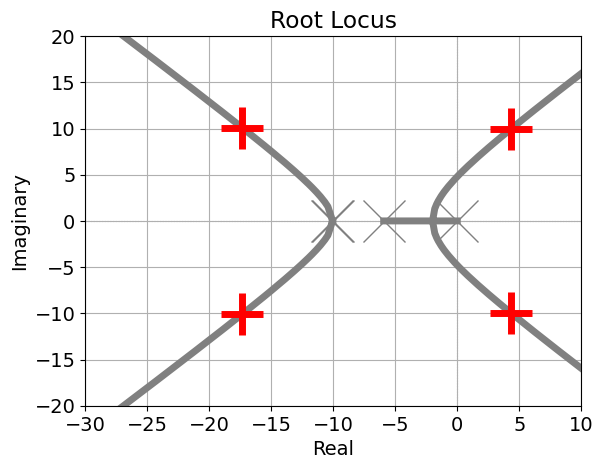

In [90]:
## RL for L_act
# if SystemName in ['Selkov','Selkov1','Selkov3']:
#     xlim=(-10,20)
#     ylim=(-10,10)
# else:
#     xlim=(-30,20)
#     ylim=(-20,20)
SetPlot(RL=True)
roots1,gains1 = con.root_locus(L_act,kvect=[1],plot=False)
roots,gains=con.root_locus(L_act,xlim=xlim,ylim=ylim,grid=False)
plt.plot(np.real(roots1),np.imag(roots1),color='r', marker='+',mew=5)
plt.grid()
SaveFig(SysName,'SplitRootLocus_act')
SetPlot()

## Sisotool

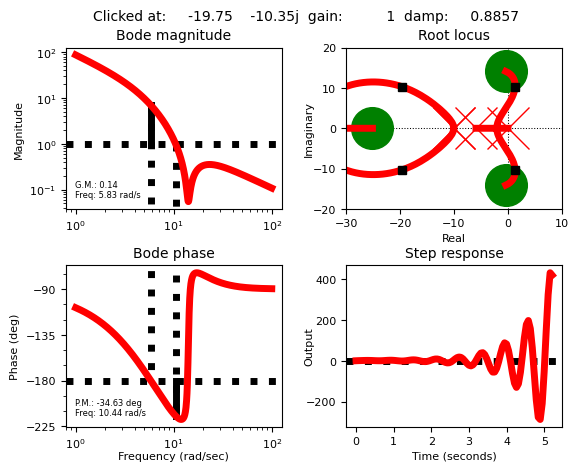

In [91]:
con.sisotool(L,xlim_rlocus=xlim,ylim_rlocus=ylim)
SaveFig(SysName,'SplitSisoTool')

## Sisotool - active only

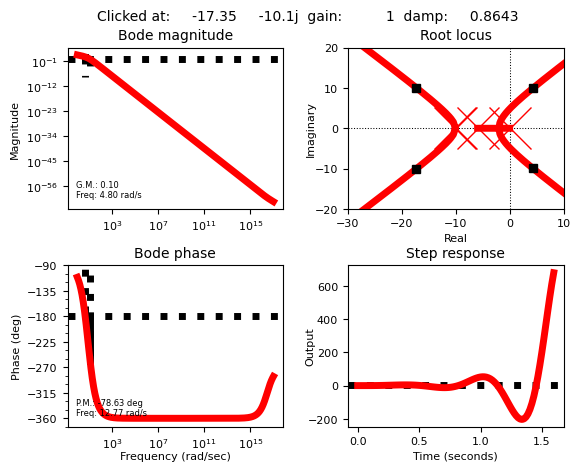

In [92]:
con.sisotool(L_act,xlim_rlocus=xlim,ylim_rlocus=ylim)
SaveFig(SysName,'SplitSisoTool')

Text(0.5, 0, '$\\omega$ rad/sec ($\\omega_c = 10$)')

Text(0, 0.5, '$|L|$')

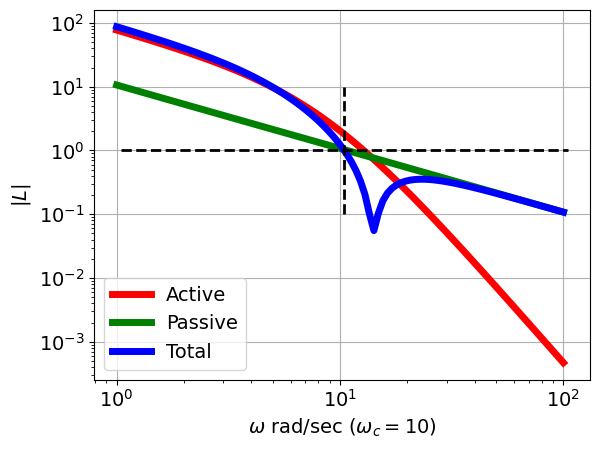

In [93]:
Name = ['Active','Passive','Total']
for i,l in enumerate(L_list):
#     print(i,l)
    mag,phase,om = con.bode_plot(l,omega,plot=False)
    plt.loglog(omega,mag,label=Name[i])
plt.hlines(1,wcp/10,wcp*10,ls='dashed',color='black',lw=2)  
plt.vlines(wcp,0.1,10,ls='dashed',color='black',lw=2)
plt.legend(loc='lower left')
plt.grid()
plt.xlabel(f'$\\omega$ rad/sec ($\\omega_c = {int(round(wcp))}$)')
plt.ylabel(r'$|L|$')
SaveFig(SysName,'SplitBodeMag')

Text(0.5, 0, '$\\omega$ rad/sec ($\\theta_{pm} = -35^\\circ$)')

Text(0, 0.5, '$\\angle{L}$')

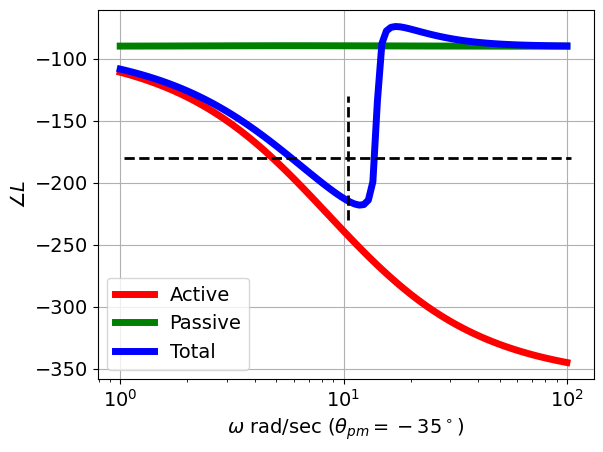

In [94]:
for i,l in enumerate(L_list):
#     print(i,l)
    mag,phase,om = con.bode_plot(l,omega,plot=False)
    phase_deg = phase*180/np.pi
    plt.semilogx(omega,phase_deg,label=Name[i])
plt.legend()
plt.hlines(-180,wcp/10,wcp*10,ls='dashed',color='black',lw=2)  
plt.vlines(wcp,-230,-130,ls='dashed',color='black',lw=2)

# plt.xlabel(r'$\omega$')
plt.xlabel(f'$\\omega$ rad/sec ($\\theta_{{pm}} = {int(round(pm))}^\circ$)')

plt.ylabel(r'$\angle{L}$')
plt.grid()
SaveFig(SysName,'SplitBodePha')

2

(-2.0, 1.0)

(-1.0, 1.0)

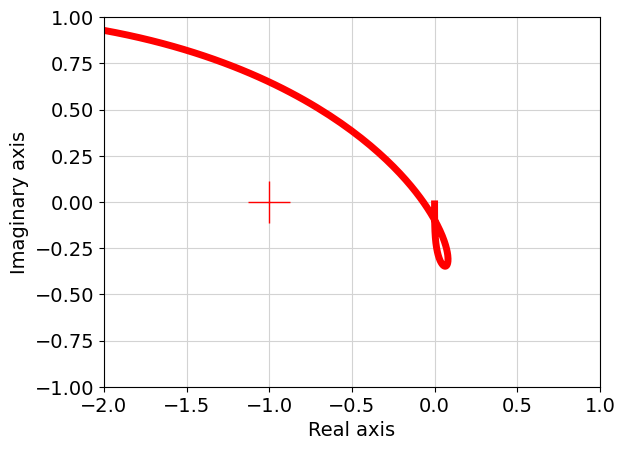

In [95]:
con.nyquist_plot([LL],mirror_style=False)
plt.xlim(-2,1)
plt.ylim(-1,1)


[2, 0]

(-3.0, 0.5)

(-2.0, 2.0)

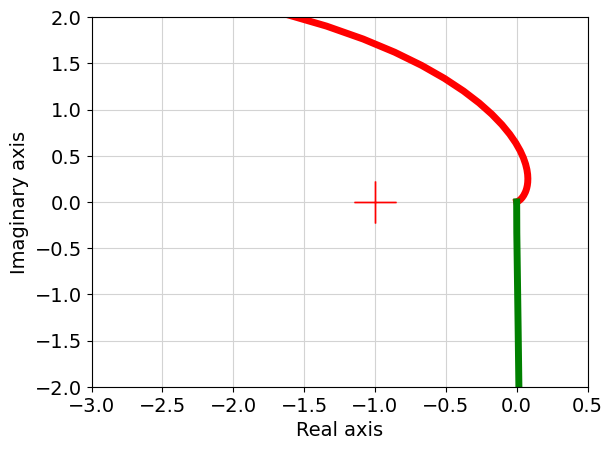

In [96]:
con.nyquist_plot([L_act,L_pas],mirror_style=False)
plt.xlim(-3,0.5)
plt.ylim(-2,2)


# Open-loop analysis of dynamic part of Toy and Goodwin examples

In [97]:
if SystemName in ['Toy','Goodwin']:
    
    # Stoichiometry 
    chemostats,parameter,InpVar,OutpVar,T,T_long,n_red = SetAll(SystemName,Config='Dynamic',quiet=False)
    s,sc = stoichiometry(sys_abg.model(),chemostats=chemostats)

    
    species = s['species']
 
    ## Linearise
    X_ss = copy.deepcopy(x_sl_ss)
    TF,Sys = Lin(s,sc,parameter=parameter,x_ss=X_ss,outvar='dX',Inp=['E1'], Outp=['P','Pf'])

    ## Steady state values of the 3 enzymes - and product.
    x_ss_E = 1
    for i in range(3):
        Ei = 'E'+str(i+1)
        x_ss_i = X_ss[species.index(Ei)]
        print(f'{Ei} steady state: {x_ss_i:.3f}')
        x_ss_E *= x_ss_i

    print(f'P steady-state: {X_ss[species.index("P")]:.3f}')
    ## Extract transfer-functions
    
    
    for tfName in ['E1_P','E1_Pf']:
        print(tfName)
        tf = TF[tfName]
        OL_d_0 = tf
        # print(OL_d_0)
        OL_d = IntegrateTF(OL_d_0)
        print(OL_d)
        print(con.poles(OL_d))
        g = con.dcgain(OL_d)
        print(f'Gain: {g:.2e} ({g/x_ss_E:.3e})')



Setting feedback loop with configuration Dynamic
1 states have been removed from the model
3 states have been removed from the model
E1 steady state: 0.168
E2 steady state: 0.283
E3 steady state: 0.794
P steady-state: 5.936
E1_P

             2.819e+05
-----------------------------------
(s + 10.03) (s + 10.08) (s + 10.63)

[-10.63108265+0.j -10.08007675+0.j -10.02837804+0.j]
Gain: 2.62e+02 (6.927e+03)
E1_Pf

  -5.936
----------
s + 0.1685

[-0.16845782+0.j]
Gain: -3.52e+01 (-9.305e+02)


In [98]:
con.config.defaults['xferfcn.display_format'] = 'zpk'

# Linear + saturation

In [99]:

def linpos_fun(tt,x):
    global _A_MATRIX_
    global _MIN_STATE_
    dx = _A_MATRIX_@x
    # if x[0]<-10:
    #     dx[0] = 0
    # print(dx.shape)
    
    for i,xx in enumerate(x):
        min = _MIN_STATE_[i]
        if xx<min:
            # print(i)
            x[i] = min
    return dx
    
def linpos(A,x0,x_ss_0,t_span):
    global _A_MATRIX_
    global _MIN_STATE_
    _A_MATRIX_ = A
    _MIN_STATE_ = -1*np.array(x_ss_0)
    ret = integrate.solve_ivp(linpos_fun, t_span, x0, max_step=0.01)
    t = ret['t']
    x = ret['y']
    dx = _A_MATRIX_@x

    return t,x.T,dx.T

In [100]:
## Extract variable states
x_ss_0 = []
species_0 = []
for spec in species_open:
    if spec not in chemostats_open:
        species_0.append(spec)
## con.feedback puts P state first - so prepend
species_0 = ['P'] + species_0

for spec in species_0:
    x = x_ss_open[species.index(spec)]
    print(spec,x)
    x_ss_0.append(x)
print(x_ss_0)  
print(species_0)

P 5.93620393877866
E1 0.16845782427848063
E2 0.28297834855767506
E3 0.7944071039555537
[5.93620393877866, 0.16845782427848063, 0.28297834855767506, 0.7944071039555537]
['P', 'E1', 'E2', 'E3']


[5.93620393877866, 0.16845782427848063, 0.28297834855767506, 0.7944071039555537]


TransferFunction(array([1.]), array([ 1., -0.]))

StateSpace(array([[-5.83775182e+00, -1.00162294e-02, -1.68504791e-02],
       [-3.35836750e+01, -1.01268955e+01,  1.33395544e-01],
       [ 0.00000000e+00, -5.61458680e+00, -1.00800114e+01]]), array([[-16.84557716],
       [ -0.0493836 ],
       [  0.06691153]]), array([[ -0.        ,  -0.        , -14.94510746]]), array([[10.79954047]]))

<LinearIOSystem:sys[227]:['u[0]']->['y[0]']>

<LinearICSystem:sys[229]:['u[0]']->['y[0]']>

['sys[227]_x[0]', 'sys[82]_x[0]', 'sys[82]_x[1]', 'sys[82]_x[2]']

(4, 4)

(4,)

2.657990146241061e-06


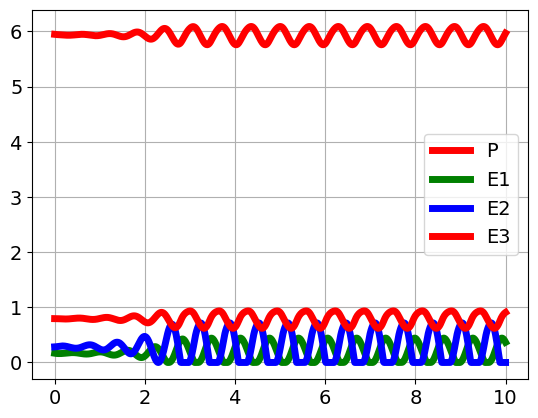

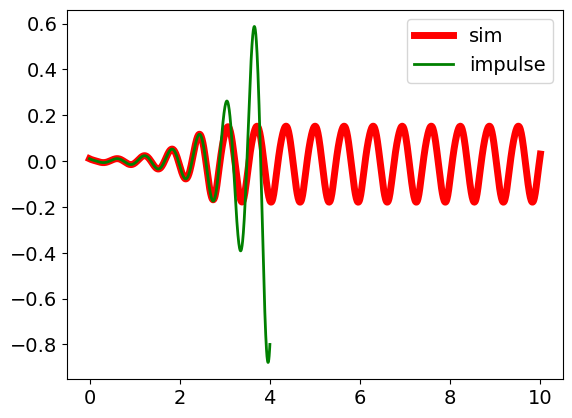

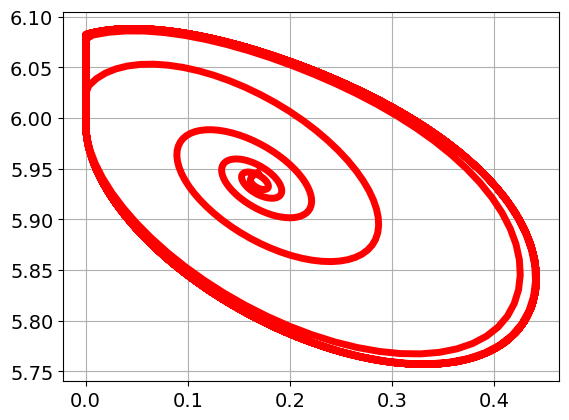

In [101]:
if SystemName in ['Toy']:
    print(x_ss_0)
    timespan = [0,10]
    x0 = np.zeros(len(x_ss_0))
    # Pert = 1e-2
    x0[0] = pert

    Intsys = con.ss(0,1,1,0)
    con.tf(Intsys)
    linsys = con.feedback(Intsys,L0_sys)

    ## Show systems
    L0_sys
    Intsys
    linsys
    linsys.state_labels
    A = copy.copy(linsys.A)
    A.shape
    x0.shape
    
    tt,x,dx = linpos(A,x0,x_ss_0,timespan)
    X = x + x_ss_0

    print(x[1,3])
    plt.plot(tt,X)
    
    plt.grid()
    plt.legend(species_0)
    plt.show()
    
    plt.plot(tt,x[:,0],label='sim')
    plt.plot(T,y_cll*pert,label='impulse',lw=2)
    
    # plt.xlim(0,2)
    plt.legend()
    plt.show()
    
    plt.plot(X[:,1],X[:,0])

    plt.grid()

## Signals at integrator

['fb_Act', 'fb_E0', 'E1', 'E2', 'E3', 'P', 'Pf', 'decr1_A', 'decr1_Zf', 'decr2_A', 'decr2_Zf', 'decr3_A', 'decr3_Zf']


Text(0.5, 0, '$x_P$')

Text(0, 0.5, '$\\dot{x}_P$')

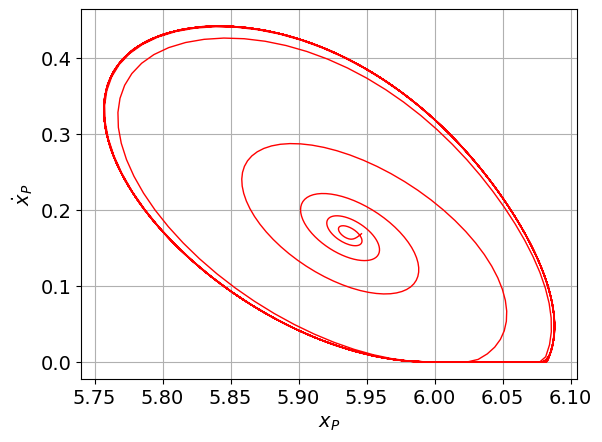

In [102]:
if SystemName in ['Toy']:

    print(species)
    i_P = 0 # See above
    i_E1 = 1
    x_X = X[:,i_P]
    x_Y = X[:,i_E1]
    plt.plot(x_X,x_Y,lw=1)
    plt.xlabel('$x_P$')
    plt.ylabel('$\dot{x}_P$')
    # plt.xlim(left=0)
    # plt.ylim(bottom=0)
    plt.grid()
    
    SaveFig(SysName,'PhasePlaneP')

In [103]:
## Optionally save data
print(SysName)
if SaveData:
    file = open(f'{SysName}.dat', 'wb')
    pickle.dump(SavedData, file)
    file.close()

Toy
